# GCN Models to Compute Heritage Values and Attributes

## Imports

In [1]:
import os
import os.path as osp
from itertools import product
from typing import Callable, List, Optional

import numpy as np
import scipy.sparse as sp

from torch_geometric.data import (
    HeteroData,
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import pandas as pd

import random

import torch
torch.manual_seed(1337)
torch.backends.cudnn.benchmark = True

from torch_geometric.transforms import RandomLinkSplit, ToUndirected
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv, Linear, to_hetero
from torch_geometric.utils import to_undirected

import torch.nn.functional as F
from torch_geometric import seed_everything

from tqdm import tqdm
import torch.optim as optim
import pickle

In [3]:
from torch_geometric.nn import GCNConv, Linear, GCN2Conv
from torch_geometric.nn.conv.gcn_conv import gcn_norm

In [4]:
from torch_cluster import knn_graph

In [5]:
os.getcwd()

'D:\\surf\\TUD\\Paper\\Venice_Graph'

In [6]:
print("PyTorch version {}".format(torch.__version__))
print("GPU-enabled installation? {}".format(torch.cuda.is_available()))

PyTorch version 1.10.2
GPU-enabled installation? True


In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(device)

cuda:0


In [8]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if cuda:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [9]:
args = Namespace(
    # Data and Path information
    path = 'dataset/Venice',
    save_dir='model_storage/GCN/',
    model_state_file='model.pth',
    
    # Model hyper parameters
    hidden_channels = 2048,
    num_layers = 9,
    k=3,
    use_gdc=True,
    
    # Training hyper parameters
    sample_nodes = 25,
    batch_size=32,
    early_stopping_criteria=100,
    learning_rate=0.001,
    l2=2e-4,
    dropout_p=0.2,
    num_epochs=500,
    seed=42,
    
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

In [10]:
if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))

# handle dirs
handle_dirs(args.save_dir)    

Expanded filepaths: 
	model_storage/GCN/model.pth


## Constructing Dataset

In [11]:
class VEN(InMemoryDataset):
    r"""A subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (1,190 nodes), nodes with both visual and textual
    features 'vis_tex' (1,761 nodes) and four types of links - social similarity
    'SOC' (488,103 links), spatial similarity (445,779 links), temporal similarity
    (501,191 links), and simple composed link (1,071,977 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 2,951
              - 1,071,977
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['vis_only', 'vis_tex']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        for src, dst in product(node_types, node_types):
            for link in link_types:
                A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz'))[s[src]][:,s[dst]].tocoo()
                if A_sub.nnz>0:
                    row = torch.from_numpy(A_sub.row).to(torch.long)
                    col = torch.from_numpy(A_sub.col).to(torch.long)
                    data[src, f'{link}_link', dst].edge_index = torch.stack([row, col], dim=0)
                    data[src, f'{link}_link', dst].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)


        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [11]:
class VEN_Homo(InMemoryDataset):
    r"""A subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_Homo is a homogeneous graph containing 2951 nodes and 1,071,977 links.
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 2,951
              - 1,071,977
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = Data()

        link_types = ['simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])

        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data.num_nodes = len(node_type_idx)

        data.x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data.y = torch.from_numpy(ys).to(torch.float)

        data.node_type = node_type_idx
        
        data.att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data.val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data.num_nodes, dtype=torch.bool)
            mask[idx] = True
            data[f'{name}_mask'] = mask
                    
        s = {}
        
        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data.edge_index = torch.stack([row, col], dim=0)
                data.edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [16]:
class VEN_XL(InMemoryDataset):
    r"""A large subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_XL is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (31,140 nodes), nodes with both visual and textual
    features 'vis_tex' (49,823 nodes) and four types of links - social similarity
    'SOC' (76,422,265 links), spatial similarity (202,173,159 links), temporal similarity
    (71,135,671 links), and simple composed link (290,091,503 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 80,963
              - 290,091,503
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1QZ5tyUWs6jYjh7mJrsnpou76iy-vb0CA'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['vis_only', 'vis_tex']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        for src, dst in product(node_types, node_types):
            for link in link_types:
                A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz'))[s[src]][:,s[dst]].tocoo()
                if A_sub.nnz>0:
                    row = torch.from_numpy(A_sub.row).to(torch.long)
                    col = torch.from_numpy(A_sub.col).to(torch.long)
                    data[src, f'{link}_link', dst].edge_index = torch.stack([row, col], dim=0)
                    data[src, f'{link}_link', dst].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)


        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [17]:
class VEN_XL_Homo(InMemoryDataset):
    r"""A large subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_XL is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (31,140 nodes), nodes with both visual and textual
    features 'vis_tex' (49,823 nodes) and four types of links - social similarity
    'SOC' (76,422,265 links), spatial similarity (202,173,159 links), temporal similarity
    (71,135,671 links), and simple composed link (290,091,503 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 80,963
              - 290,091,503
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = Data()

        link_types = ['simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])

        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data.num_nodes = len(node_type_idx)

        data.x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data.y = torch.from_numpy(ys).to(torch.float)
        
        data.att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data.val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data.num_nodes, dtype=torch.bool)
            mask[idx] = True
            data[f'{name}_mask'] = mask
                    
        s = {}
        
        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data.edge_index = torch.stack([row, col], dim=0)
                data.edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [18]:
class VEN_XL_knn(InMemoryDataset):
    r"""A large subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_XL is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (31,140 nodes), nodes with both visual and textual
    features 'vis_tex' (49,823 nodes) and four types of links - social similarity
    'SOC' (76,422,265 links), spatial similarity (202,173,159 links), temporal similarity
    (71,135,671 links), and simple composed link (290,091,503 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 80,963
              - 290,091,503
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = Data()

        link_types = ['simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])

        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data.num_nodes = len(node_type_idx)

        data.x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data.y = torch.from_numpy(ys).to(torch.float)
        
        data.att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data.val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data.num_nodes, dtype=torch.bool)
            mask[idx] = True
            data[f'{name}_mask'] = mask
                    
        s = {}
        
        data.edge_index = knn_graph(data.x[:,:982].to(torch.device("cuda:0")), k=3, loop=False, cosine=True).to(torch.device("cpu"))
        
        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [12]:
#path = osp.join(os.getcwd(), '../../data/VEN')
transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_Homo('dataset/Venice_homo')
data = dataset[0]

In [16]:
#path = osp.join(os.getcwd(), '../../data/VEN')
transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_Homo('dataset/Venice_homo')
data_0 = dataset[0]

In [99]:
#path = osp.join(os.getcwd(), '../../data/VEN')
transform = T.Compose([T.ToSparseTensor()])
dataset = VEN_Homo_Vis('dataset/Venice_vis', transform=transform)
data = dataset[0]

In [19]:
data = data.to(device)

In [ ]:
data.adj_t = gcn_norm(data.adj_t)  # Pre-process GCN normalization.

In [20]:
data.n_id = torch.arange(data.num_nodes)
data = data.to(device)
data

Data(num_nodes=2951, x=[2951, 1753], y=[2951, 20], node_type=[2951], att_lab=[2951], val_lab=[2951], train_mask=[2951], val_mask=[2951], test_mask=[2951], edge_index=[2, 1071977], edge_attr=[1071977], n_id=[2951])

In [21]:
data.x

tensor([[1.2861, 0.3745, 1.1453,  ..., 1.0000, 0.0000, 0.0000],
        [0.3977, 0.1582, 0.3059,  ..., 1.0000, 0.0000, 0.0000],
        [0.5185, 0.5124, 1.3662,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.0124, 1.7083, 0.3258,  ..., 0.0000, 1.0000, 0.0000],
        [0.4402, 0.8374, 0.4974,  ..., 0.0000, 1.0000, 0.0000],
        [0.2102, 1.5535, 0.3352,  ..., 0.0000, 1.0000, 0.0000]],
       device='cuda:0')

## Data Loader for Sampling

In [13]:
from torch_geometric.loader import NeighborLoader

In [14]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)

In [15]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)

In [16]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [17]:
data

Data(num_nodes=2951, x=[2951, 1753], y=[2951, 20], node_type=[2951], att_lab=[2951], val_lab=[2951], train_mask=[2951], val_mask=[2951], test_mask=[2951], edge_index=[2, 1071977], edge_attr=[1071977])

In [18]:
sampled_data = next(iter(train_loader))
batch = sampled_data
batch

Data(num_nodes=2944, x=[2944, 1753], y=[2944, 20], node_type=[2944], att_lab=[2944], val_lab=[2944], train_mask=[2944], val_mask=[2944], test_mask=[2944], edge_index=[2, 104039], edge_attr=[104039], batch_size=32)

In [19]:
batch['train_mask'].sum()

tensor(360)

## Helper Function

In [20]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_ATT_acc_val': 0,
            'early_stopping_best_VAL_acc_val': 0,
            'early_stopping_best_ATT_acc_val_2': 0,
            'early_stopping_lowest_loss': 1000,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_ATT_loss': [],
            'train_VAL_loss':[],
            'train_ATT_acc': [],
            'train_VAL_acc': [],
            'train_VAL_jac': [],
            'train_VAL_acc_1':[], 
            'val_loss': [],
            'val_ATT_loss': [],
            'val_VAL_loss':[],
            'val_ATT_acc': [],
            'val_VAL_acc': [],
            'val_VAL_jac': [],
            'val_VAL_acc_1': [],
            'test_loss': -1,
            'test_ATT_loss': -1,
            'test_VAL_loss':-1,
            'test_ATT_acc': -1,
            'test_VAL_acc': -1,
            'test_VAL_jac': -1,
            'test_VAL_acc_1': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        ATT_acc_tm1, ATT_acc_t = train_state['val_ATT_acc'][-2:]
        #ATT_acc_2_tm1, ATT_acc_2_t = train_state['val_ATT_acc_2'][-2:]
        VAL_acc_tm1, VAL_acc_t = train_state['val_VAL_acc'][-2:]
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If accuracy worsened
        #if loss_t >= train_state['early_stopping_lowest_loss']:
        #    train_state['early_stopping_step'] += 1
        
        if ATT_acc_t <= train_state['early_stopping_best_ATT_acc_val'] and VAL_acc_t <= train_state['early_stopping_best_VAL_acc_val']:# and ATT_acc_2_t <= train_state['early_stopping_best_ATT_acc_val_2']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if VAL_acc_t > train_state['early_stopping_best_VAL_acc_val']:
                train_state['early_stopping_best_VAL_acc_val'] = VAL_acc_t
                
            if ATT_acc_t > train_state['early_stopping_best_ATT_acc_val']:
                train_state['early_stopping_best_ATT_acc_val'] = ATT_acc_t
            
            #if ATT_acc_2_t > train_state['early_stopping_best_ATT_acc_val_2']:
            #    train_state['early_stopping_best_ATT_acc_val_2'] = ATT_acc_2_t
                
            if loss_t < train_state['early_stopping_lowest_loss']:
                train_state['early_stopping_lowest_loss'] = loss_t
                torch.save(model.state_dict(), train_state['model_filename'])
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [21]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [22]:
def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

## Searched Best Hyper-Parameter

In [40]:
with open(args.save_dir+'42_new/hyperdict.p', 'rb') as fp:
    hyperdict= pickle.load(fp)

In [45]:
with open(args.save_dir+'42/hyperdict.p', 'rb') as fp:
    hyperdict= pickle.load(fp)

In [33]:
with open(args.save_dir+'42_old/hyperdict.p', 'rb') as fp:
    hyperdict= pickle.load(fp)

In [46]:
len(hyperdict)

135

In [47]:
hyper_df = pd.DataFrame(hyperdict).T

In [43]:
hyper_df[(hyper_df.early_stopping_best_VAL_acc_val + hyper_df.early_stopping_best_VAL_acc_val)>192]

stop_early early_stopping_step  \
0.1 3 1024 0.0001      False                   0   
      2048 0.0001      False                  42   
0.2 3 1024 0.0001      False                   9   

                  early_stopping_best_ATT_acc_val  \
0.1 3 1024 0.0001                       70.359712   
      2048 0.0001                       77.410072   
0.2 3 1024 0.0001                       74.676259   

                  early_stopping_best_VAL_acc_val  \
0.1 3 1024 0.0001                       97.122302   
      2048 0.0001                       96.258993   
0.2 3 1024 0.0001                       96.258993   

                  early_stopping_best_ATT_acc_val_2  \
0.1 3 1024 0.0001                                 0   
      2048 0.0001                                 0   
0.2 3 1024 0.0001                                 0   

                  early_stopping_lowest_loss learning_rate epoch_index  \
0.1 3 1024 0.0001                   4.607598        0.0001         499   
      2048 0.0001                   4.458251        0.0001         499   
0.2 3 1024 0.0001                     4.4983        0.0001         499   

                                                          train_loss  \
0.1 3 1024 0.0001  [2613.5779876708984, 1204.9343363444011, 701.9...   
      2048 0.0001  [5090.649505615234, 1869.1582285563152, 819.53...   
0.2 3 1024 0.0001  [2428.3749084472656, 1191.4395701090496, 730.5...   

                                                      train_ATT_loss  ...  \
0.1 3 1024 0.0001  [1155.9296631535665, 336.5252560010577, 145.32...  ...   
      2048 0.0001  [2021.7496973603056, 657.8490275121462, 238.72...  ...   
0.2 3 1024 0.0001  [944.1573300348424, 268.61363866916986, 209.73...  ...   

                                                         val_VAL_acc  \
0.1 3 1024 0.0001  [70.2158273381295, 51.94244604316547, 36.40287...   
      2048 0.0001  [67.62589928057554, 47.05035971223022, 44.8920...   
0.2 3 1024 0.0001  [34.82014388489208, 41.8705035971223, 68.20143...   

                                                         val_VAL_jac  \
0.1 3 1024 0.0001  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      2048 0.0001  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0.2 3 1024 0.0001  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                  test_loss test_ATT_loss test_VAL_loss test_ATT_acc  \
0.1 3 1024 0.0001        -1            -1            -1           -1   
      2048 0.0001        -1            -1            -1           -1   
0.2 3 1024 0.0001        -1            -1            -1           -1   

                  test_ATT_acc_2 test_VAL_acc test_VAL_jac  \
0.1 3 1024 0.0001             -1           -1           -1   
      2048 0.0001             -1           -1           -1   
0.2 3 1024 0.0001             -1           -1           -1   

                                model_filename  
0.1 3 1024 0.0001  model_storage/GCN/model.pth  
      2048 0.0001  model_storage/GCN/model.pth  
0.2 3 1024 0.0001  model_storage/GCN/model.pth  

[3 rows x 29 columns]

In [48]:
hyper_df[(hyper_df.early_stopping_best_VAL_acc_val + hyper_df.early_stopping_best_VAL_acc_val)>192]

,,,,stop_early,early_stopping_step,early_stopping_best_ATT_acc_val,early_stopping_best_VAL_acc_val,early_stopping_best_ATT_acc_val_2,early_stopping_lowest_loss,learning_rate,epoch_index,train_loss,train_ATT_loss,...,val_VAL_jac,val_VAL_acc_1,test_loss,test_ATT_loss,test_VAL_loss,test_ATT_acc,test_VAL_acc,test_VAL_jac,test_VAL_acc_1,model_filename
0.1,3,2048,0.0001,False,42,60.0,97.934803,0,6.985767,0.0001,499,"[20680.238444010418, 8601.111348470053, 3549.9...","[8161.654882880129, 3437.9267037093146, 1715.7...",...,"[0.2186393742612979, 0.1133393006690581, 0.205...","[25.23000789039621, 12.919268583025758, 20.363...",-1,-1,-1,-1,-1,-1,-1,model_storage/GCN/model.pth
0.2,3,2048,0.0001,False,6,61.438849,97.253675,0,6.90887,0.0001,499,"[19789.836385091145, 8336.638427734375, 3870.4...","[8090.332441081631, 2346.382003150158, 1352.74...",...,"[0.2193358559987425, 0.3028092792700629, 0.248...","[24.44686744682694, 35.117017163913566, 25.791...",-1,-1,-1,-1,-1,-1,-1,model_storage/GCN/model.pth


In [44]:
hyper_df[(hyper_df.early_stopping_lowest_loss<4.5)]

stop_early early_stopping_step  \
0.1 3 128  0.0100      False                   5   
      2048 0.0001      False                  42   
0.2 3 1024 0.0001      False                   9   
      2048 0.0001      False                  34   
0.5 3 128  0.0100      False                   0   

                  early_stopping_best_ATT_acc_val  \
0.1 3 128  0.0100                       78.273381   
      2048 0.0001                       77.410072   
0.2 3 1024 0.0001                       74.676259   
      2048 0.0001                       77.985612   
0.5 3 128  0.0100                        73.81295   

                  early_stopping_best_VAL_acc_val  \
0.1 3 128  0.0100                       81.582734   
      2048 0.0001                       96.258993   
0.2 3 1024 0.0001                       96.258993   
      2048 0.0001                       94.532374   
0.5 3 128  0.0100                       95.827338   

                  early_stopping_best_ATT_acc_val_2  \
0.1 3 128  0.0100                                 0   
      2048 0.0001                                 0   
0.2 3 1024 0.0001                                 0   
      2048 0.0001                                 0   
0.5 3 128  0.0100                                 0   

                  early_stopping_lowest_loss learning_rate epoch_index  \
0.1 3 128  0.0100                   4.415502          0.01         499   
      2048 0.0001                   4.458251        0.0001         499   
0.2 3 1024 0.0001                     4.4983        0.0001         499   
      2048 0.0001                   4.455007        0.0001         499   
0.5 3 128  0.0100                   4.454536          0.01         499   

                                                          train_loss  \
0.1 3 128  0.0100  [27222.7026163737, 536.5198364257812, 126.3412...   
      2048 0.0001  [5090.649505615234, 1869.1582285563152, 819.53...   
0.2 3 1024 0.0001  [2428.3749084472656, 1191.4395701090496, 730.5...   
      2048 0.0001  [4728.126159667969, 2131.298899332682, 918.385...   
0.5 3 128  0.0100  [16091.682729085287, 639.2374471028646, 87.748...   

                                                      train_ATT_loss  ...  \
0.1 3 128  0.0100  [494.35288261772854, 91.04551318477726, 11.722...  ...   
      2048 0.0001  [2021.7496973603056, 657.8490275121462, 238.72...  ...   
0.2 3 1024 0.0001  [944.1573300348424, 268.61363866916986, 209.73...  ...   
      2048 0.0001  [2286.1785141371624, 647.7904076404519, 315.76...  ...   
0.5 3 128  0.0100  [1044.7446490258721, 73.34946832630443, 12.695...  ...   

                                                         val_VAL_acc  \
0.1 3 128  0.0100  [9.784172661870503, 77.26618705035972, 40.0, 7...   
      2048 0.0001  [67.62589928057554, 47.05035971223022, 44.8920...   
0.2 3 1024 0.0001  [34.82014388489208, 41.8705035971223, 68.20143...   
      2048 0.0001  [70.2158273381295, 75.53956834532374, 75.53956...   
0.5 3 128  0.0100  [40.0, 75.53956834532374, 70.35971223021583, 3...   

                                                         val_VAL_jac  \
0.1 3 128  0.0100  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      2048 0.0001  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0.2 3 1024 0.0001  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      2048 0.0001  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0.5 3 128  0.0100  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                  test_loss test_ATT_loss test_VAL_loss test_ATT_acc  \
0.1 3 128  0.0100        -1            -1            -1           -1   
      2048 0.0001        -1            -1            -1           -1   
0.2 3 1024 0.0001        -1            -1            -1           -1   
      2048 0.0001        -1            -1            -1           -1   
0.5 3 128  0.0100        -1            -1            -1           -1   

                  test_ATT_acc_2 test_VAL_acc test_VAL_jac  \
0.1 3 128  0.0100             -1  

## Re-run model and get Inference Data

In [23]:
class GCN2_L(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, alpha, theta,
                 shared_weights=True, dropout=0.0):
        super().__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(Linear(in_channels, hidden_channels))
        self.lins.append(Linear(hidden_channels, out_channels))

        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(
                GCN2Conv(hidden_channels, alpha, theta, layer + 1,
                         shared_weights, normalize=False))

        self.dropout = dropout

    def forward(self, x, adj_t):
        x = F.dropout(x, self.dropout, training=self.training)
        x = x_0 = self.lins[0](x).relu()

        for conv in self.convs:
            h = F.dropout(x, self.dropout, training=self.training)
            h = conv(x, x_0, adj_t)
            x = h + x
            x = x.relu()

        x = F.dropout(x, self.dropout, training=self.training)
        x = self.lins[1](x)

        return x

In [22]:
def train_Homo(model, optimizer, train_loader):
    model.train()

    total_examples = total_loss = 0
    for batch in tqdm(train_loader):
        batch.edge_index = to_undirected(batch.edge_index)
        trans = T.ToSparseTensor()
        batch = trans(batch)
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = args.batch_size
        out = model(batch.x, batch.adj_t)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        y = batch.y
        y_att = y[:,:9]
        y_val = y[:,9:]
        
        loss = F.cross_entropy(out_att, y_att[:batch_size]) + F.cross_entropy(out_val, y_val[:batch_size])
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

@torch.no_grad()
def test_Homo(model, loader):
    model.eval()

    total_examples_att = total_examples_val = 0
    running_loss_1 = running_loss_2 = 0.
    running_1_acc = 0.
    running_k_acc = 0.
    running_k_jac = 0.
    running_1_val = 0.
    
    for batch in tqdm(loader):
        loss_1 = 0
        acc_1_t = 0
        loss_2 = 0
        acc_1_val = 0
        acc_k_t = 0
        jac_k_t = 0

        batch.edge_index = to_undirected(batch.edge_index)
        trans = T.ToSparseTensor()
        batch = trans(batch)
        batch = batch.to(device)
        batch_size = batch.batch_size
        out = model(batch.x, batch.adj_t)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        att_node = (batch.att_lab[:batch_size]).nonzero().squeeze()
        val_node = (batch.val_lab[:batch_size]).nonzero().squeeze()

        #print(type_node)

        #pred_att = out_att.argmax(dim=-1)
        #pred_val = out_val.argmax(dim=-1)

        y = batch.y
        y_att = y[:,:9]
        y_val = y[:,9:]

        if not att_node.shape[0]==0:
            loss_1 = F.cross_entropy(out_att[att_node], y_att[:batch_size][att_node])
            acc_1_t = compute_1_accuracy(y_att[:batch_size][att_node], out_att[att_node])

        if not val_node.shape[0]==0:
            loss_2 = F.cross_entropy(out_val[val_node], y_val[val_node])
            acc_1_val = compute_1_accuracy(y_val[val_node], out_val[val_node])
            acc_k_t = compute_k_accuracy(y_val[val_node], out_val[val_node], args.k)
            jac_k_t = compute_jaccard_index(y_val[val_node], F.softmax(out_val[val_node],dim=-1), args.k)
            #loss_3 = loss_1 + loss_2

        total_examples_att += att_node.shape[0]
        total_examples_val += val_node.shape[0]
        #total_correct_att += int((pred_att == y_att[:batch_size]).sum())
        #total_correct_val += int((pred_val == y_val[:batch_size]).sum())

        running_loss_1 += float(loss_1) * att_node.shape[0]
        running_loss_2 += float(loss_2) * val_node.shape[0]
        running_1_acc += float(acc_1_t) * att_node.shape[0]
        running_1_val += float(acc_1_val) * val_node.shape[0]
        running_k_acc += float(acc_k_t) * val_node.shape[0]
        running_k_jac += float(jac_k_t) * val_node.shape[0]

    return running_loss_1/total_examples_att, running_loss_2/total_examples_val, running_1_acc/ total_examples_att, running_k_acc/ total_examples_val, running_k_jac/ total_examples_val, running_1_val/total_examples_val


In [23]:
def initialization():
    set_seed_everywhere(args.seed, args.cuda)
    transform = T.Compose([T.ToSparseTensor()])
    dataset = VEN_Homo('dataset/Venice_homo')
    data = dataset[0].to(device)
    #data.adj_t = gcn_norm(data.adj_t)
    
    train_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling training nodes
        batch_size=args.batch_size,
        input_nodes=data.train_mask,
    )
    val_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling validating nodes
        batch_size=args.batch_size,
        input_nodes=data.val_mask,
    )
    test_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling testing nodes
        batch_size=args.batch_size,
        input_nodes=data.test_mask,
    )
 
    model = GCN2_L(in_channels=data.x.shape[-1], hidden_channels = 2048, 
            out_channels = data.y.shape[-1], dropout = 0.1, num_layers = 3, alpha=0.5, 
            theta = 1.0, shared_weights=False).to(device)
    return data, model, train_loader, val_loader, test_loader

In [35]:
def training_loop(verbose=False):
    
    _, model, train_loader, val_loader, test_loader = initialization()
    if torch.cuda.device_count() > 1:
        print("Use {} GPUs !".format(torch.cuda.device_count()))
        model = DataParallel(model)
    
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=args.l2)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
    #                                           mode='min', factor=0.5,
    #                                           patience=1)

    train_state = make_train_state(args)

    try:
        for epoch in range(args.num_epochs):
            train_state['epoch_index'] = epoch
            
            loss = train_Homo(model, optimizer, train_loader)
            train_loss_att, train_loss_val, train_att_acc, train_val_acc, train_val_jac, train_val_1 = test_Homo(model, train_loader)
            val_loss_att, val_loss_val, val_att_acc, val_val_acc, val_val_jac, val_val_1 = test_Homo(model, val_loader)
            if verbose:
                print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train_ATT: {train_att_acc:.4f}, Train_VAL: {train_val_acc:.4f}, Val_vis_tex_ATT: {val_att_acc:.4f}, Val_vis_tex_VAL: {val_val_acc:.4f}')
            
            train_state['train_loss'].append(loss)
            train_state['train_ATT_loss'].append(train_loss_att)
            train_state['train_VAL_loss'].append(train_loss_val)
            train_state['train_ATT_acc'].append(train_att_acc)
            train_state['train_VAL_acc'].append(train_val_acc)
            train_state['train_VAL_jac'].append(train_val_jac)
            train_state['train_VAL_acc_1'].append(train_val_1)
            
            train_state['val_ATT_loss'].append(val_loss_att)
            train_state['val_VAL_loss'].append(val_loss_val)
            train_state['val_loss'].append(val_loss_att + 3*val_loss_val)
            train_state['val_ATT_acc'].append(val_att_acc)
            train_state['val_VAL_acc'].append(val_val_acc)
            train_state['val_VAL_jac'].append(val_val_jac)
            train_state['val_VAL_acc_1'].append(val_val_1)
            
            train_state = update_train_state(args=args, model=model,
                                                train_state=train_state)
            if train_state['stop_early']:
                break

    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

In [36]:
batch

Data(num_nodes=2942, x=[2942, 1753], y=[2942, 20], node_type=[2942], att_lab=[2942], val_lab=[2942], train_mask=[2942], val_mask=[2942], test_mask=[2942], edge_index=[2, 105276], edge_attr=[105276], n_id=[2942], batch_size=32)

In [ ]:
train_state = training_loop(verbose=True)

In [38]:
model = GCN2_L(in_channels=data.x.shape[-1], hidden_channels = 2048, 
            out_channels = data.y.shape[-1], dropout = 0.1, num_layers = 3, alpha=0.5, 
            theta = 1.0, shared_weights=False).to(device)

In [39]:
model.load_state_dict(torch.load(args.save_dir+'GCN_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [40]:
model

GCN2_L(
  (lins): ModuleList(
    (0): Linear(1753, 2048, bias=True)
    (1): Linear(2048, 20, bias=True)
  )
  (convs): ModuleList(
    (0): GCN2Conv(2048, alpha=0.5, beta=0.6931471805599453)
    (1): GCN2Conv(2048, alpha=0.5, beta=0.4054651081081644)
    (2): GCN2Conv(2048, alpha=0.5, beta=0.28768207245178085)
  )
)

In [41]:
set_seed_everywhere(args.seed, args.cuda)
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 19.52it/s]


In [42]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.74it/s]


(0.8631061644105039,
 1.6387795170258288,
 97.78393351800554,
 97.50692520775624,
 0.7082179167264055,
 76.17728531855956)

In [43]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 17.57it/s]


(1.3769353877722732,
 1.6643998487829574,
 67.47967479674797,
 98.0295566502463,
 0.6412151094727916,
 75.36945812807882)

In [44]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 18.51it/s]


(1.3970716539955519,
 1.7004521451890469,
 69.58250497017893,
 95.3125,
 0.5946180559694767,
 68.75)

In [45]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 24.84it/s]


In [46]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [47]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.390449,1.665622,67.581301,97.783251,0.655172,73.645320
std,0.006084,0.002347,0.651605,0.625269,0.011184,1.070477
min,1.381590,1.662473,66.260163,96.551724,0.640394,72.413793
25%,1.386564,1.664275,67.276423,97.536946,0.647373,72.536946
50%,1.390121,1.665213,67.581301,98.029557,0.653530,73.891626
75%,1.394043,1.666143,67.835366,98.029557,0.660509,74.261084
max,1.399647,1.670667,68.495935,98.522167,0.675698,75.369458


In [48]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.391325,1.699112,70.536779,95.572917,0.612413,67.291667
std,0.006515,0.002469,0.990938,0.368285,0.007853,1.448379
min,1.383618,1.695573,68.588469,94.791667,0.598958,65.104167
25%,1.385492,1.696837,70.178926,95.312500,0.607205,66.666667
50%,1.392564,1.699599,70.278330,95.833333,0.613281,66.927083
75%,1.393310,1.700824,71.222664,95.833333,0.617622,68.229167
max,1.404516,1.702729,71.968191,95.833333,0.625000,69.791667


In [49]:
val_df.to_csv(args.save_dir + 'val_metrics.csv', sep='\t')
test_df.to_csv(args.save_dir + 'test_metrics.csv', sep='\t')

In [50]:
train_state['test_ATT_loss']=test_loss_att
train_state['test_VAL_loss']=test_loss_val
train_state['test_loss']=test_loss_att + 3*test_loss_val
train_state['test_ATT_acc']=test_att_acc
train_state['test_VAL_acc_1']=test_val_1
train_state['test_VAL_acc']=test_val_acc
train_state['test_VAL_jac']=test_val_jac

In [51]:
train_state

{'stop_early': False,
 'early_stopping_step': 16,
 'early_stopping_best_ATT_acc_val': 68.4959349593496,
 'early_stopping_best_VAL_acc_val': 99.01477832512315,
 'early_stopping_best_ATT_acc_val_2': 0,
 'early_stopping_lowest_loss': 6.374089079415671,
 'learning_rate': 0.001,
 'epoch_index': 499,
 'train_loss': [21686.502888997395,
  7073.636149088542,
  3457.987589518229,
  2238.019241333008,
  1684.2134399414062,
  1335.973035176595,
  1100.2035115559895,
  926.5936915079752,
  798.7615814208984,
  645.3673375447592,
  743.8019638061523,
  648.2982991536459,
  536.2037124633789,
  511.0992488861084,
  381.57089869181317,
  286.8625717163086,
  212.23640950520834,
  181.6116428375244,
  131.7418998082479,
  115.90013694763184,
  90.33860619862874,
  73.78545014063518,
  47.58559878667196,
  31.87571318944295,
  26.304145971934002,
  16.085876782735188,
  9.831242561340332,
  8.12470829486847,
  6.638039628664653,
  5.7093425989151,
  5.294069409370422,
  4.830312212308248,
  5.008777777

In [52]:
with open(args.save_dir+'GCN_best_model/best_config.p', 'wb') as fp:
    pickle.dump(train_state,fp, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
with open(args.save_dir+'GCN_best_model/best_config.p', 'rb') as fp:
    train_state = pickle.load(fp)

In [54]:
states = pd.DataFrame(train_state['val_VAL_acc'], columns=['val_VAL'])
states['train_VAL'] = pd.DataFrame(train_state['train_VAL_acc'])
states['val_ATT'] = pd.DataFrame(train_state['val_ATT_acc'])
states['train_ATT'] = pd.DataFrame(train_state['train_ATT_acc'])
states['val_VAL_1'] = pd.DataFrame(train_state['val_VAL_acc_1'])
states['train_VAL_1'] = pd.DataFrame(train_state['train_VAL_acc_1'])
states['train_VAL_jac'] = pd.DataFrame(train_state['train_VAL_jac'])
states['val_VAL_jac'] = pd.DataFrame(train_state['val_VAL_jac'])

In [55]:
states

,val_VAL,train_VAL,val_ATT,train_ATT,val_VAL_1,train_VAL_1,train_VAL_jac,val_VAL_jac
0,55.665025,56.786704,28.252033,27.977839,24.630542,21.883657,0.210065,0.248768
1,63.546798,66.759003,21.544715,23.822715,16.748768,21.883657,0.234995,0.169130
2,61.576355,59.002770,18.699187,16.897507,20.689655,24.376731,0.226685,0.215928
3,59.113300,59.833795,4.471545,6.925208,25.615764,24.653740,0.236380,0.261084
4,72.413793,73.407202,21.138211,19.113573,32.019704,26.869806,0.271930,0.298030
...,...,...,...,...,...,...,...,...
495,97.044335,99.722992,66.056911,98.060942,74.384236,74.792244,0.702678,0.642036
496,95.566502,98.060942,63.211382,98.891967,71.921182,78.116343,0.689289,0.643678
497,98.029557,98.891967,66.463415,99.445983,72.906404,77.839335,0.686057,0.668309
498,97.536946,99.168975,64.227642,98.614958,72.906404,74.515235,0.707756,0.650246


In [56]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

<AxesSubplot:>

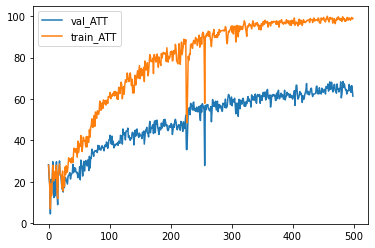

In [57]:
states[['val_ATT','train_ATT']].plot()

<AxesSubplot:>

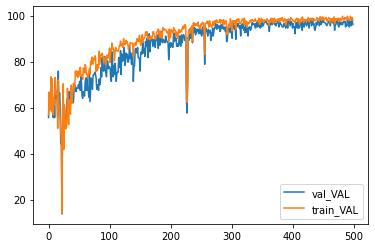

In [58]:
states[['val_VAL','train_VAL']].plot()

<AxesSubplot:>

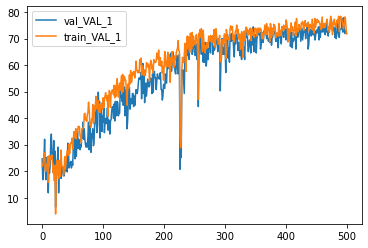

In [59]:
states[['val_VAL_1','train_VAL_1']].plot()

<AxesSubplot:>

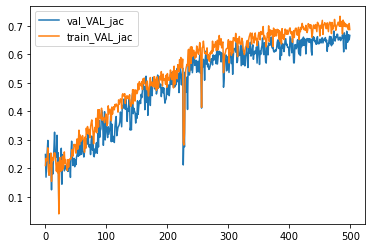

In [60]:
states[['val_VAL_jac','train_VAL_jac']].plot()

In [61]:
train_state['train_loss']

[21686.502888997395,
 7073.636149088542,
 3457.987589518229,
 2238.019241333008,
 1684.2134399414062,
 1335.973035176595,
 1100.2035115559895,
 926.5936915079752,
 798.7615814208984,
 645.3673375447592,
 743.8019638061523,
 648.2982991536459,
 536.2037124633789,
 511.0992488861084,
 381.57089869181317,
 286.8625717163086,
 212.23640950520834,
 181.6116428375244,
 131.7418998082479,
 115.90013694763184,
 90.33860619862874,
 73.78545014063518,
 47.58559878667196,
 31.87571318944295,
 26.304145971934002,
 16.085876782735188,
 9.831242561340332,
 8.12470829486847,
 6.638039628664653,
 5.7093425989151,
 5.294069409370422,
 4.830312212308248,
 5.008777777353923,
 4.50720198949178,
 4.465625166893005,
 4.1943060755729675,
 4.2378528118133545,
 4.154225091139476,
 4.170975923538208,
 4.166011114915212,
 4.0423387090365095,
 4.02793687582016,
 3.9784698486328125,
 3.9660420417785645,
 3.9444665710131326,
 3.84731125831604,
 3.876537561416626,
 3.8377997477849326,
 3.8439953525861106,
 3.8348275

In [62]:
unlabel_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=~(data.train_mask + data.val_mask + data.test_mask),
)

In [63]:
@torch.no_grad()
def predict_Homo(model, loader):
    model.eval()
    seed_everything(args.seed)
    all_preds = []
    
    for batch in tqdm(loader):
        batch.edge_index = to_undirected(batch.edge_index)
        trans = T.ToSparseTensor()
        batch = trans(batch)
        batch = batch.to(device)
        batch_size = batch.batch_size
        out = model(batch.x, batch.adj_t)[:batch_size]
        out_att = out[:,:9].softmax(axis=1)
        out_val = out[:,9:].softmax(axis=1)
        
        IDs = batch.n_id[:batch_size].unsqueeze(dim=-1).int()
        
        now = torch.hstack([IDs, out_att, out_val])
        all_preds.append(now)
    
    final = torch.vstack(all_preds)
        
    return final

In [64]:
pred_train = predict_Homo(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.05it/s]


In [65]:
pred_val = predict_Homo(model, val_loader)
pred_test = predict_Homo(model, test_loader)
pred_unlab = predict_Homo(model, unlabel_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 36.76it/s]


In [66]:
preds = torch.vstack([pred_train, pred_val, pred_test, pred_unlab]).cpu()

In [67]:
preds[:,1:].sum(axis=1)

tensor([2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000])

In [68]:
preds_df = pd.DataFrame(preds).sort_values(0).set_index(0)

In [69]:
preds_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.051371,0.159083,0.013543,0.031652,0.247649,0.277534,0.059738,0.010287,0.149143,0.175394,0.216967,0.170923,0.198501,0.023022,0.156388,0.014863,0.013562,0.005717,0.007731,0.016932
1.0,0.069260,0.132252,0.024670,0.033616,0.247697,0.172443,0.094084,0.017248,0.208729,0.236233,0.280789,0.162350,0.136405,0.015139,0.120049,0.012817,0.009619,0.005002,0.008084,0.013513
2.0,0.044331,0.074213,0.016013,0.035584,0.245185,0.382818,0.063208,0.010501,0.128146,0.311433,0.196389,0.145003,0.139567,0.015512,0.139686,0.012236,0.012932,0.004872,0.007718,0.014651
3.0,0.037011,0.226261,0.011449,0.015987,0.064006,0.058745,0.552821,0.026916,0.006804,0.054147,0.044489,0.176752,0.087973,0.038968,0.547279,0.014850,0.009841,0.006574,0.007132,0.011994
4.0,0.105371,0.522662,0.003649,0.032924,0.108764,0.182800,0.031373,0.005440,0.007018,0.146684,0.101506,0.185065,0.261178,0.020337,0.250594,0.008339,0.006061,0.003978,0.005203,0.011056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946.0,0.013591,0.656695,0.050361,0.009859,0.005435,0.007790,0.223964,0.025450,0.006853,0.338489,0.140600,0.224368,0.177899,0.021255,0.040973,0.011893,0.016399,0.004904,0.008500,0.014720
2947.0,0.007579,0.417154,0.080186,0.006017,0.007570,0.004077,0.442677,0.029789,0.004951,0.361170,0.123729,0.231364,0.176878,0.019213,0.042162,0.008676,0.014386,0.003185,0.007139,0.012098
2948.0,0.013963,0.702686,0.033923,0.006240,0.006236,0.009493,0.199210,0.021117,0.007132,0.387396,0.126181,0.205826,0.174803,0.020224,0.038081,0.008714,0.015049,0.003403,0.007058,0.013266


In [70]:
preds_df.to_csv(args.save_dir + 'preds.csv', sep='\t')

In [71]:
states.to_csv(args.save_dir + 'train_state.csv', sep='\t')

## Per-Class Metrics

In [72]:
from sklearn.metrics import confusion_matrix

In [73]:
preds = pd.read_csv(args.save_dir + 'preds.csv', sep='\t', index_col='0')
preds

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.051371,0.159083,0.013543,0.031652,0.247649,0.277534,0.059738,0.010287,0.149143,0.175394,0.216967,0.170923,0.198501,0.023022,0.156388,0.014863,0.013562,0.005717,0.007731,0.016932
1.0,0.069260,0.132252,0.024670,0.033616,0.247697,0.172443,0.094084,0.017248,0.208729,0.236233,0.280789,0.162350,0.136405,0.015139,0.120049,0.012817,0.009619,0.005002,0.008084,0.013513
2.0,0.044331,0.074213,0.016013,0.035584,0.245185,0.382818,0.063208,0.010501,0.128146,0.311433,0.196389,0.145003,0.139567,0.015512,0.139686,0.012236,0.012932,0.004872,0.007718,0.014651
3.0,0.037011,0.226261,0.011449,0.015987,0.064006,0.058745,0.552821,0.026916,0.006804,0.054147,0.044489,0.176752,0.087973,0.038968,0.547279,0.014850,0.009841,0.006574,0.007132,0.011994
4.0,0.105371,0.522662,0.003649,0.032924,0.108764,0.182800,0.031373,0.005440,0.007018,0.146684,0.101506,0.185065,0.261178,0.020337,0.250594,0.008339,0.006061,0.003978,0.005203,0.011056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946.0,0.013591,0.656695,0.050361,0.009859,0.005435,0.007790,0.223964,0.025450,0.006853,0.338489,0.140600,0.224368,0.177899,0.021255,0.040973,0.011893,0.016399,0.004904,0.008500,0.014720
2947.0,0.007579,0.417154,0.080186,0.006017,0.007570,0.004077,0.442677,0.029789,0.004951,0.361170,0.123729,0.231364,0.176878,0.019213,0.042162,0.008676,0.014386,0.003185,0.007139,0.012098
2948.0,0.013963,0.702686,0.033923,0.006240,0.006236,0.009493,0.199210,0.021117,0.007132,0.387396,0.126181,0.205826,0.174803,0.020224,0.038081,0.008714,0.015049,0.003403,0.007058,0.013266


In [74]:
pred = torch.tensor(np.array(preds)).to(device)

In [75]:
def top_k_confusion_matrix(y, y_pred, k=3):
    dim = y.shape[-1]
    y = y.topk(k=k, axis=1)[1]
    y_pred = y_pred.topk(k=k, axis=1)[1]
    conf = np.zeros((dim, dim))
    for i in range(k):
        for j in range(k):
            conf = np.add(conf, confusion_matrix(y[:,i], y_pred[:,j], labels = range(dim)))
    return conf

In [76]:
test_ATT_conf = confusion_matrix(data.y[(data.att_lab) * data.test_mask][:,:9].argmax(axis=1).cpu(), 
                                 pred[(data.att_lab) * data.test_mask][:,:9].argmax(axis=1).cpu(), labels = range(9))
test_VAL_conf = confusion_matrix(data.y[(data.val_lab) * data.test_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[(data.val_lab) * data.test_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(data.y[(data.val_lab) * data.test_mask][:,9:].cpu(),  
                                 pred[(data.val_lab) * data.test_mask][:,9:].cpu(),3)).astype(int)

In [77]:
test_ATT_conf

array([[ 48,   7,   0,   1,   0,   5,   3,   0,   0],
       [  0, 121,   2,   1,   6,  10,   1,   0,   4],
       [  0,   1,   8,   0,   0,   0,   2,   0,   0],
       [  4,   1,   0,  12,   0,   0,   1,   0,   0],
       [  0,  13,   2,   0,  46,   6,   3,   0,   2],
       [  3,  21,   1,   0,   3,  73,   0,   0,   1],
       [  0,  20,   3,   2,   8,   3,  41,   0,   0],
       [  0,   1,   0,   0,   0,   0,   1,   0,   0],
       [  0,   3,   1,   0,   2,   5,   0,   0,   1]], dtype=int64)

In [78]:
test_VAL_conf

array([[54,  2,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 6, 15,  0,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  2, 18,  4,  0,  8,  0,  0,  0,  0,  0],
       [ 7,  1,  5, 17,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 6,  3,  5,  2,  0, 28,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [79]:
test_VAL_conf_k

array([[ 89,  44,  56,  51,   0,  42,   0,   0,   0,   0,   0],
       [ 63,  70,  68,  65,   1,  42,   0,   0,   0,   0,   0],
       [ 67,  48, 115, 101,   0,  77,   0,   0,   0,   0,   0],
       [ 66,  50,  93, 116,   1,  73,   0,   0,   0,   0,   0],
       [  0,   3,   2,   3,   1,   0,   0,   0,   0,   0,   0],
       [ 45,  25,  76,  74,   0,  89,   0,   0,   0,   0,   0],
       [  1,   0,   2,   1,   0,   2,   0,   0,   0,   0,   0],
       [  1,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [80]:
val_ATT_conf = confusion_matrix(data.y[(data.att_lab) * data.val_mask][:,:9].argmax(axis=1).cpu(), 
                                pred[(data.att_lab) * data.val_mask][:,:9].argmax(axis=1).cpu())
val_VAL_conf = confusion_matrix(data.y[(data.val_lab) * data.val_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[(data.val_lab) * data.val_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(data.y[(data.val_lab) * data.val_mask][:,9:].cpu(),  
                                 pred[(data.val_lab) * data.val_mask][:,9:].cpu(),3)).astype(int)

In [81]:
val_ATT_conf

array([[ 49,   3,   0,   0,   2,   4,   2,   0,   1],
       [  0, 121,   0,   0,   6,   8,   2,   0,   9],
       [  0,   1,   4,   0,   0,   0,   3,   0,   0],
       [  6,   2,   1,  10,   1,   2,   0,   0,   0],
       [  0,  15,   0,   1,  47,   7,   4,   0,   1],
       [  3,  17,   1,   1,   3,  76,   0,   0,   2],
       [  0,  17,   1,   0,   9,   2,  32,   0,   1],
       [  0,   0,   1,   0,   1,   0,   3,   0,   0],
       [  0,   5,   0,   0,   3,   1,   0,   0,   1]], dtype=int64)

In [82]:
val_VAL_conf

array([[62,  2,  1,  2,  0,  2,  0,  0,  0,  0,  0],
       [ 3, 12,  1,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 5,  0, 17,  6,  0,  3,  0,  0,  0,  0,  0],
       [ 2,  6,  1, 23,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5,  5,  2,  0,  0, 38,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [83]:
val_VAL_conf_k

array([[ 98,  57,  65,  62,   0,  42,   0,   0,   0,   0,   0],
       [ 66,  82,  66,  72,   1,  34,   0,   0,   0,   0,   0],
       [ 66,  48, 107,  99,   0,  72,   0,   0,   0,   1,   0],
       [ 76,  68,  98, 118,   1,  64,   0,   0,   0,   1,   0],
       [  1,   8,   4,   8,   1,   2,   0,   0,   0,   0,   0],
       [ 50,  40,  92,  73,   0,  83,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [84]:
pd.concat([pd.DataFrame(val_ATT_conf),pd.DataFrame(test_ATT_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_ATT.csv')
pd.concat([pd.DataFrame(val_VAL_conf),pd.DataFrame(test_VAL_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL.csv')
pd.concat([pd.DataFrame(val_VAL_conf_k),pd.DataFrame(test_VAL_conf_k)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_k.csv')

In [85]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001)
        recall = val/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [86]:
def per_class_metrics_k(confusion_matrix, classes, k=3):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val*k/(row.sum()+0.000000001)
        recall = val*k/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [87]:
classes = ['Criterion i', 'Criterion ii', 'Criterion iii', 'Criterion iv', 'Criterion v', 'Criterion vi', 
              'Criterion vii', 'Criterion viii', 'Criterion ix', 'Criterion x', 'Others']
categories = ['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and Land-scape Scenery',
 'Monuments and Buildings',
 'Peoples Activity and Association',
 'Artifact Products',
 'Urban Scenery']

In [88]:
metrics_dict = {}
metrics_dict['test_ATT'] = per_class_metrics(test_ATT_conf, categories)
metrics_dict['val_ATT'] = per_class_metrics(val_ATT_conf, categories)
metrics_dict['test_VAL'] = per_class_metrics(test_VAL_conf, classes)
metrics_dict['val_VAL'] = per_class_metrics(val_VAL_conf, classes)
metrics_dict['test_VAL_k'] = per_class_metrics_k(test_VAL_conf_k, classes)
metrics_dict['val_VAL_k'] = per_class_metrics_k(val_VAL_conf_k, classes)

In [89]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [90]:
metrics_df.to_csv(args.save_dir+'per_class_metrics.csv')

## TEM links

In [91]:
#path = osp.join(os.getcwd(), '../../data/VEN')
#transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_tem('dataset/Venice_tem')
data = dataset[0]

In [92]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)
seed_everything(args.seed)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)
seed_everything(args.seed)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [93]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.31it/s]


(2.642172353089351,
 3.2311722723731044,
 60.664819944598335,
 72.29916897506925,
 0.3130193971861102,
 43.49030470914128)

In [94]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 19.31it/s]


(3.5443887819604174,
 3.4948819341330695,
 40.24390243902439,
 70.93596059113301,
 0.2643678176579217,
 35.467980295566505)

In [95]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 17.00it/s]


(3.5256952867356257,
 3.1433422788977623,
 43.141153081510936,
 75.0,
 0.29774305783212185,
 45.833333333333336)

In [96]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 19.85it/s]


In [97]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [98]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,3.554615,3.474805,41.524390,70.591133,0.272496,35.270936
std,0.014885,0.047861,0.736273,0.332487,0.004248,0.344436
min,3.538757,3.387748,40.447154,69.950739,0.266010,34.975369
25%,3.547162,3.445136,41.107724,70.443350,0.269294,34.975369
50%,3.551225,3.476186,41.361789,70.443350,0.272578,35.221675
75%,3.553377,3.515573,41.819106,70.935961,0.276067,35.467980
max,3.581351,3.541972,42.886179,70.935961,0.279146,35.960591


In [99]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,3.476622,3.063219,42.644135,74.843750,0.289236,46.197917
std,0.015115,0.066079,1.006112,1.099385,0.009938,1.126467
min,3.453196,2.984251,40.755467,73.437500,0.271701,44.791667
25%,3.462261,3.006047,42.743539,73.958333,0.285373,45.312500
50%,3.485177,3.055701,42.942346,74.479167,0.288628,46.354167
75%,3.486832,3.116841,43.091451,75.911458,0.292535,47.135417
max,3.492108,3.169579,43.936382,76.562500,0.310764,47.916667


In [100]:
val_df.to_csv(args.save_dir + 'TEM_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'TEM_test_metrics_transfer.csv', sep='\t')

## SPA links

In [101]:
#path = osp.join(os.getcwd(), '../../data/VEN')
#transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_spa('dataset/Venice_spa')
data = dataset[0]

In [102]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)
seed_everything(args.seed)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)
seed_everything(args.seed)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [103]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.75it/s]


(1.7039049497271508,
 1.9112678795970377,
 72.85318559556787,
 90.02770083102493,
 0.4764543041958373,
 56.232686980609415)

In [104]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 11.48it/s]


(1.9269959536509784,
 1.9946264116634875,
 49.390243902439025,
 89.16256157635468,
 0.4449917923640735,
 55.172413793103445)

In [105]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:02<00:00,  9.89it/s]


(1.819129412027287,
 2.104668963700533,
 53.47912524850894,
 84.89583333333333,
 0.41276042597989243,
 53.645833333333336)

In [106]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 11.38it/s]


In [107]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [108]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.938973,1.991101,49.146341,90.394089,0.450985,57.832512
std,0.014972,0.004806,0.728438,0.778886,0.007818,0.934663
min,1.914085,1.987966,47.357724,89.162562,0.436782,56.157635
25%,1.927631,1.988491,49.034553,89.778325,0.445813,57.266010
50%,1.942243,1.989472,49.186992,90.394089,0.452791,57.881773
75%,1.949362,1.990858,49.542683,91.009852,0.456486,58.128079
max,1.958179,2.003812,50.000000,91.625616,0.462233,59.605911


In [109]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.813513,2.113320,54.612326,84.791667,0.388455,51.406250
std,0.007387,0.003167,0.440078,1.427417,0.015322,1.534274
min,1.800937,2.108549,53.677932,81.770833,0.366753,48.958333
25%,1.808830,2.110350,54.473161,84.505208,0.374566,50.651042
50%,1.813564,2.114060,54.671968,84.895833,0.389323,51.562500
75%,1.820349,2.115586,54.821074,85.416667,0.400608,52.343750
max,1.821759,2.117681,55.268390,86.979167,0.408420,54.166667


In [110]:
val_df.to_csv(args.save_dir + 'SPA_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'SPA_test_metrics_transfer.csv', sep='\t')

## SOC links

In [111]:
#path = osp.join(os.getcwd(), '../../data/VEN')
#transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_soc('dataset/Venice_soc')
data = dataset[0]

In [112]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)
seed_everything(args.seed)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)
seed_everything(args.seed)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [113]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.84it/s]


(2.091365894782576,
 2.296313564533012,
 61.21883656509695,
 74.51523545706371,
 0.3656509748126001,
 47.64542936288089)

In [114]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 13.30it/s]


(4.017390344685655,
 2.2948006450249054,
 44.51219512195122,
 69.45812807881774,
 0.3374384234985107,
 43.8423645320197)

In [115]:
set_seed_everywhere(args.seed, args.cuda)
test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 15.25it/s]


(3.6768672975820764,
 2.4180735188225904,
 50.89463220675945,
 76.5625,
 0.34461806264395517,
 49.479166666666664)

In [116]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 15.71it/s]


In [117]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [118]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.012843,2.315637,45.365854,71.428571,0.371470,46.009852
std,0.013192,0.016765,0.676150,1.354058,0.007174,1.118515
min,3.991964,2.291848,44.308943,69.458128,0.364532,44.334975
25%,4.003919,2.307548,44.969512,70.320197,0.366790,45.073892
50%,4.015484,2.314420,45.528455,71.428571,0.369458,46.059113
75%,4.022445,2.324025,45.934959,72.290640,0.371819,46.674877
max,4.031053,2.349422,46.138211,73.891626,0.385878,47.783251


In [119]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,3.688108,2.417258,51.332008,74.270833,0.323958,49.270833
std,0.008081,0.024533,1.143213,1.130474,0.014678,1.997660
min,3.670593,2.386405,49.900596,72.916667,0.305556,45.312500
25%,3.685263,2.398059,50.497018,73.437500,0.311957,48.046875
50%,3.687562,2.416526,51.192843,74.479167,0.320747,49.218750
75%,3.694433,2.435258,51.888668,74.869792,0.336914,50.911458
max,3.698491,2.457018,53.677932,76.562500,0.347222,52.083333


In [120]:
val_df.to_csv(args.save_dir + 'SOC_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'SOC_test_metrics_transfer.csv', sep='\t')

## Using kNN Feature

In [24]:
def initialization_knn():
    set_seed_everywhere(args.seed, args.cuda)
    #transform = T.Compose([T.ToSparseTensor()])
    dataset = VEN_Homo('dataset/Venice_homo')
    data = dataset[0]
    data.n_id = torch.arange(data.num_nodes)
    edge_index = knn_graph(data.x[:,:982].to(device), k=3, loop=False, cosine=True)
    data.edge_index = edge_index
    data = data.to(device)
    
    train_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling training nodes
        batch_size=args.batch_size,
        input_nodes=data.train_mask,
    )
    val_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling validating nodes
        batch_size=args.batch_size,
        input_nodes=data.val_mask,
    )
    test_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling testing nodes
        batch_size=args.batch_size,
        input_nodes=data.test_mask,
    )
 
    model = GCN2_L(in_channels=data.x.shape[-1], hidden_channels = 2048, 
            out_channels = data.y.shape[-1], dropout = 0.1, num_layers = 3, alpha=0.5, 
            theta = 1.0, shared_weights=False).to(device)
    return data, model, train_loader, val_loader, test_loader

In [25]:
def training_loop_knn(verbose=False):
    
    _, model, train_loader, val_loader, test_loader = initialization_knn()
    if torch.cuda.device_count() > 1:
        print("Use {} GPUs !".format(torch.cuda.device_count()))
        model = DataParallel(model)
    
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=args.l2)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
    #                                           mode='min', factor=0.5,
    #                                           patience=1)

    train_state = make_train_state(args)

    try:
        for epoch in range(args.num_epochs):
            train_state['epoch_index'] = epoch
            
            loss = train_Homo(model, optimizer, train_loader)
            train_loss_att, train_loss_val, train_att_acc, train_val_acc, train_val_jac, train_val_1 = test_Homo(model, train_loader)
            val_loss_att, val_loss_val, val_att_acc, val_val_acc, val_val_jac, val_val_1 = test_Homo(model, val_loader)
            if verbose:
                print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train_ATT: {train_att_acc:.4f}, Train_VAL: {train_val_acc:.4f}, Val_vis_tex_ATT: {val_att_acc:.4f}, Val_vis_tex_VAL: {val_val_acc:.4f}')
            
            train_state['train_loss'].append(loss)
            train_state['train_ATT_loss'].append(train_loss_att)
            train_state['train_VAL_loss'].append(train_loss_val)
            train_state['train_ATT_acc'].append(train_att_acc)
            train_state['train_VAL_acc'].append(train_val_acc)
            train_state['train_VAL_jac'].append(train_val_jac)
            train_state['train_VAL_acc_1'].append(train_val_1)
            
            train_state['val_ATT_loss'].append(val_loss_att)
            train_state['val_VAL_loss'].append(val_loss_val)
            train_state['val_loss'].append(val_loss_att + 3*val_loss_val)
            train_state['val_ATT_acc'].append(val_att_acc)
            train_state['val_VAL_acc'].append(val_val_acc)
            train_state['val_VAL_jac'].append(val_val_jac)
            train_state['val_VAL_acc_1'].append(val_val_1)
            
            train_state = update_train_state(args=args, model=model,
                                                train_state=train_state)
            if train_state['stop_early']:
                break

    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

In [ ]:
train_state = training_loop_knn(verbose=True)

In [26]:
#path = osp.join(os.getcwd(), '../../data/VEN')
transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_Homo('dataset/Venice_homo')
data_0 = dataset[0]
data_0.n_id = torch.arange(data_0.num_nodes)
data_0 = data_0.to(device)
data_0

Data(num_nodes=2951, x=[2951, 1753], y=[2951, 20], node_type=[2951], att_lab=[2951], val_lab=[2951], train_mask=[2951], val_mask=[2951], test_mask=[2951], edge_index=[2, 1071977], edge_attr=[1071977], n_id=[2951])

In [27]:
edge_index = knn_graph(data_0.x[:,:982].to(device), k=3, loop=False, cosine=True)

In [28]:
data_0.edge_index = edge_index
data_0 = data_0.to(device)
data_0

Data(num_nodes=2951, x=[2951, 1753], y=[2951, 20], node_type=[2951], att_lab=[2951], val_lab=[2951], train_mask=[2951], val_mask=[2951], test_mask=[2951], edge_index=[2, 8853], edge_attr=[1071977], n_id=[2951])

In [29]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data_0,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)

In [30]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data_0,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)

In [31]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data_0,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [180]:
model = GCN2_L(in_channels=data_0.x.shape[-1], hidden_channels = 2048, 
            out_channels = data.y.shape[-1], dropout = 0.1, num_layers = 3, alpha=0.5, 
            theta = 1.0, shared_weights=False).to(device)

In [181]:
model.load_state_dict(torch.load(args.save_dir+'GCN_knn_feature/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [182]:
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test_Homo(model, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.29it/s]


In [183]:
test_Homo(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.66it/s]


(0.7322701937273929,
 1.603045195423665,
 100.0,
 100.0,
 0.8513388805442239,
 86.98060941828255)

In [184]:
test_Homo(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 55.32it/s]


(0.8503701556019667,
 1.6419591116787764,
 91.869918699187,
 99.50738916256158,
 0.6921182312988883,
 74.38423645320196)

In [185]:
test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 69.56it/s]


(0.8426583606016564,
 1.6691845692694187,
 93.83697813121272,
 98.4375,
 0.6840277885397276,
 72.91666666666667)

In [186]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.64it/s]


In [187]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [188]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.00000,10.000000,10.000000,10.000000,10.000000,1.000000e+01
mean,0.85037,1.641959,91.869919,99.507389,0.692118,7.438424e+01
std,0.00000,0.000000,0.000000,0.000000,0.000000,1.497956e-14
min,0.85037,1.641959,91.869919,99.507389,0.692118,7.438424e+01
25%,0.85037,1.641959,91.869919,99.507389,0.692118,7.438424e+01
50%,0.85037,1.641959,91.869919,99.507389,0.692118,7.438424e+01
75%,0.85037,1.641959,91.869919,99.507389,0.692118,7.438424e+01
max,0.85037,1.641959,91.869919,99.507389,0.692118,7.438424e+01


In [189]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.0000,1.000000e+01,1.000000e+01
mean,0.842658,1.669185,93.836978,98.4375,6.840278e-01,7.291667e+01
std,0.000000,0.000000,0.000000,0.0000,1.170278e-16,1.497956e-14
min,0.842658,1.669185,93.836978,98.4375,6.840278e-01,7.291667e+01
25%,0.842658,1.669185,93.836978,98.4375,6.840278e-01,7.291667e+01
50%,0.842658,1.669185,93.836978,98.4375,6.840278e-01,7.291667e+01
75%,0.842658,1.669185,93.836978,98.4375,6.840278e-01,7.291667e+01
max,0.842658,1.669185,93.836978,98.4375,6.840278e-01,7.291667e+01


In [190]:
val_df.to_csv(args.save_dir + 'knn_val_metrics.csv', sep='\t')
test_df.to_csv(args.save_dir + 'knn_test_metrics.csv', sep='\t')

In [191]:
train_state['test_ATT_loss']=test_loss_att
train_state['test_VAL_loss']=test_loss_val
train_state['test_loss']=test_loss_att + 3*test_loss_val
train_state['test_ATT_acc']=test_att_acc
train_state['test_VAL_acc_1']=test_val_1
train_state['test_VAL_acc']=test_val_acc
train_state['test_VAL_jac']=test_val_jac

In [192]:
train_state

{'stop_early': True,
 'early_stopping_step': 100,
 'early_stopping_best_ATT_acc_val': 92.47967479674797,
 'early_stopping_best_VAL_acc_val': 99.50738916256158,
 'early_stopping_best_ATT_acc_val_2': 0,
 'early_stopping_lowest_loss': 5.776247490638296,
 'learning_rate': 0.001,
 'epoch_index': 206,
 'train_loss': [3.98488187789917,
  2.9202568928400674,
  2.7275574008623757,
  2.675436556339264,
  2.587629795074463,
  2.525697429974874,
  2.500541607538859,
  2.476648449897766,
  2.462872485319773,
  2.452885886033376,
  2.445234934488932,
  2.437424143155416,
  2.4283730586369834,
  2.429448207219442,
  2.417985121409098,
  2.4122249484062195,
  2.4116178353627524,
  2.4063844879468284,
  2.414516886075338,
  2.4116774996121726,
  2.409377415974935,
  2.412409007549286,
  2.4087891379992166,
  2.4128825068473816,
  2.4066702127456665,
  2.3855835596720376,
  2.3885658184687295,
  2.394146720568339,
  2.3820367058118186,
  2.3808824022610984,
  2.3658336202303567,
  2.3579464157422385,
  

In [193]:
with open(args.save_dir+'GCN_knn_feature/best_config.p', 'wb') as fp:
    pickle.dump(train_state,fp, protocol=pickle.HIGHEST_PROTOCOL)

In [194]:
with open(args.save_dir+'GCN_knn_feature/best_config.p', 'rb') as fp:
    train_state = pickle.load(fp)

In [195]:
states = pd.DataFrame(train_state['val_VAL_acc'], columns=['val_VAL'])
states['train_VAL'] = pd.DataFrame(train_state['train_VAL_acc'])
states['val_ATT'] = pd.DataFrame(train_state['val_ATT_acc'])
states['train_ATT'] = pd.DataFrame(train_state['train_ATT_acc'])
states['val_VAL_1'] = pd.DataFrame(train_state['val_VAL_acc_1'])
states['train_VAL_1'] = pd.DataFrame(train_state['train_VAL_acc_1'])
states['train_VAL_jac'] = pd.DataFrame(train_state['train_VAL_jac'])
states['val_VAL_jac'] = pd.DataFrame(train_state['val_VAL_jac'])

In [196]:
states

,val_VAL,train_VAL,val_ATT,train_ATT,val_VAL_1,train_VAL_1,train_VAL_jac,val_VAL_jac
0,84.236453,82.825485,68.292683,70.083102,48.768473,44.321330,0.427978,0.446634
1,88.177340,90.304709,84.552846,88.642659,59.605911,60.387812,0.506925,0.535304
2,88.669951,89.750693,83.739837,83.656510,56.650246,59.833795,0.529086,0.524631
3,89.655172,93.351801,88.821138,94.182825,61.083744,64.265928,0.578024,0.549261
4,92.118227,94.736842,87.804878,95.290859,61.083744,70.637119,0.620960,0.550903
...,...,...,...,...,...,...,...,...
202,98.029557,100.000000,91.056911,100.000000,71.921182,91.412742,0.899815,0.677340
203,99.014778,100.000000,89.837398,100.000000,76.354680,91.412742,0.857341,0.687192
204,99.507389,100.000000,90.447154,100.000000,76.354680,89.750693,0.853186,0.712644
205,99.014778,100.000000,91.260163,100.000000,71.921182,89.750693,0.876731,0.673235


<AxesSubplot:>

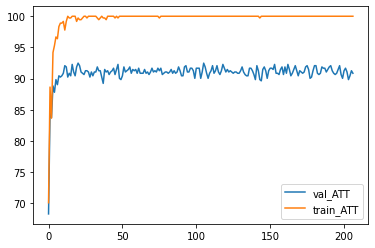

In [197]:
states[['val_ATT','train_ATT']].plot()

<AxesSubplot:>

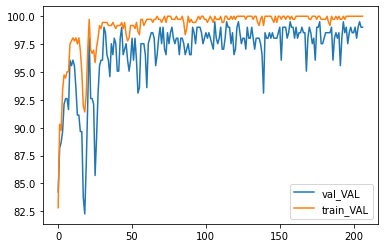

In [198]:
states[['val_VAL','train_VAL']].plot()

<AxesSubplot:>

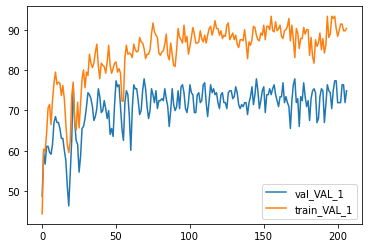

In [199]:
states[['val_VAL_1','train_VAL_1']].plot()

<AxesSubplot:>

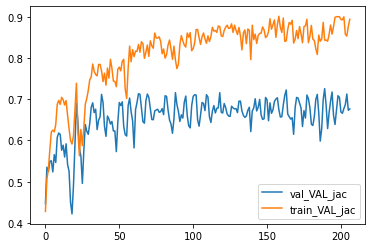

In [200]:
states[['val_VAL_jac','train_VAL_jac']].plot()

In [201]:
unlabel_loader = NeighborLoader(
    data_0,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=~(data.train_mask + data.val_mask + data.test_mask),
)

In [202]:
pred_train = predict_Homo(model, train_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 179.10it/s]


In [203]:
pred_val = predict_Homo(model, val_loader)
pred_test = predict_Homo(model, test_loader)
pred_unlab = predict_Homo(model, unlabel_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 199.94it/s]


In [204]:
preds = torch.vstack([pred_train, pred_val, pred_test, pred_unlab]).cpu()

In [205]:
preds[:,1:].sum(axis=1)

tensor([2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000])

In [206]:
preds_df = pd.DataFrame(preds).sort_values(0).set_index(0)

In [207]:
preds_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.051106,0.144581,0.016812,0.014417,0.374124,0.088118,0.085111,0.012052,0.213678,0.081602,0.285632,0.211627,0.215314,0.015925,0.161890,0.004524,0.003712,0.003713,0.004713,0.011347
1.0,0.008980,0.035098,0.004895,0.002694,0.026332,0.036283,0.008498,0.003082,0.874138,0.132893,0.344828,0.251494,0.117350,0.010432,0.113292,0.006309,0.004585,0.003817,0.005629,0.009370
2.0,0.082503,0.062681,0.008262,0.007616,0.185655,0.390743,0.039873,0.010138,0.212530,0.208880,0.236506,0.180499,0.159811,0.007967,0.186134,0.002590,0.002500,0.001750,0.002972,0.010391
3.0,0.018430,0.097028,0.030630,0.009743,0.005620,0.010180,0.775710,0.044984,0.007675,0.039365,0.023013,0.117690,0.060666,0.017713,0.704889,0.009229,0.005892,0.004494,0.009486,0.007562
4.0,0.041757,0.822288,0.007211,0.010198,0.004977,0.084740,0.018474,0.003586,0.006769,0.135850,0.091862,0.153361,0.230424,0.014515,0.356036,0.003263,0.002158,0.001777,0.002270,0.008481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946.0,0.026089,0.150923,0.209246,0.018202,0.002546,0.001706,0.485090,0.103064,0.003133,0.331747,0.089296,0.389120,0.153630,0.005097,0.023731,0.000828,0.000912,0.000783,0.001223,0.003632
2947.0,0.027706,0.105132,0.219450,0.026330,0.004392,0.002142,0.482641,0.127219,0.004989,0.334249,0.103166,0.353643,0.159461,0.008163,0.026398,0.001794,0.002156,0.001779,0.002543,0.006649
2948.0,0.118554,0.250327,0.058358,0.034282,0.008933,0.008280,0.430103,0.084490,0.006673,0.382966,0.130130,0.278880,0.141642,0.016863,0.026977,0.002699,0.003309,0.002836,0.004667,0.009031


In [208]:
preds_df.to_csv(args.save_dir + 'preds_knn.csv', sep='\t')

In [209]:
states.to_csv(args.save_dir + 'train_state_knn.csv', sep='\t')

## Per-Class Metrics

In [210]:
from sklearn.metrics import confusion_matrix

In [211]:
preds = pd.read_csv(args.save_dir + 'preds_knn.csv', sep='\t', index_col='0')
preds

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.051106,0.144581,0.016812,0.014417,0.374124,0.088118,0.085111,0.012052,0.213678,0.081602,0.285632,0.211627,0.215314,0.015925,0.161890,0.004524,0.003712,0.003713,0.004713,0.011347
1.0,0.008980,0.035098,0.004895,0.002694,0.026332,0.036283,0.008498,0.003082,0.874138,0.132893,0.344828,0.251494,0.117350,0.010432,0.113292,0.006309,0.004585,0.003817,0.005629,0.009370
2.0,0.082503,0.062681,0.008262,0.007616,0.185655,0.390743,0.039873,0.010138,0.212530,0.208880,0.236506,0.180499,0.159811,0.007967,0.186134,0.002590,0.002500,0.001750,0.002972,0.010391
3.0,0.018430,0.097028,0.030630,0.009743,0.005620,0.010180,0.775710,0.044984,0.007675,0.039365,0.023013,0.117690,0.060666,0.017713,0.704889,0.009229,0.005892,0.004494,0.009486,0.007562
4.0,0.041757,0.822288,0.007211,0.010198,0.004977,0.084740,0.018474,0.003586,0.006769,0.135850,0.091862,0.153361,0.230425,0.014515,0.356036,0.003263,0.002158,0.001777,0.002270,0.008481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946.0,0.026089,0.150923,0.209246,0.018202,0.002546,0.001706,0.485090,0.103064,0.003133,0.331747,0.089296,0.389120,0.153630,0.005097,0.023731,0.000828,0.000912,0.000783,0.001223,0.003632
2947.0,0.027706,0.105132,0.219450,0.026330,0.004392,0.002142,0.482641,0.127219,0.004989,0.334249,0.103166,0.353643,0.159461,0.008163,0.026398,0.001794,0.002156,0.001779,0.002543,0.006649
2948.0,0.118554,0.250327,0.058358,0.034282,0.008933,0.008280,0.430103,0.084490,0.006673,0.382966,0.130130,0.278880,0.141642,0.016863,0.026977,0.002699,0.003309,0.002836,0.004667,0.009031


In [212]:
pred = torch.tensor(np.array(preds)).to(device)

In [213]:
def top_k_confusion_matrix(y, y_pred, k=3):
    dim = y.shape[-1]
    y = y.topk(k=k, axis=1)[1]
    y_pred = y_pred.topk(k=k, axis=1)[1]
    conf = np.zeros((dim, dim))
    for i in range(k):
        for j in range(k):
            conf = np.add(conf, confusion_matrix(y[:,i], y_pred[:,j], labels = range(dim)))
    return conf

In [214]:
test_ATT_conf = confusion_matrix(data.y[(data.att_lab) * data.test_mask][:,:9].argmax(axis=1).cpu(), 
                                 pred[(data.att_lab) * data.test_mask][:,:9].argmax(axis=1).cpu(), labels = range(9))
test_VAL_conf = confusion_matrix(data.y[(data.val_lab) * data.test_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[(data.val_lab) * data.test_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(data.y[(data.val_lab) * data.test_mask][:,9:].cpu(),  
                                 pred[(data.val_lab) * data.test_mask][:,9:].cpu(),3)).astype(int)

In [215]:
test_ATT_conf

array([[ 63,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0, 143,   0,   0,   0,   2,   0,   0,   0],
       [  1,   0,  10,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,  16,   0,   0,   1,   0,   0],
       [  0,   3,   0,   0,  67,   0,   1,   0,   1],
       [  2,   5,   0,   0,   0,  95,   0,   0,   0],
       [  2,   3,   0,   0,   5,   0,  67,   0,   0],
       [  0,   0,   1,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0,  11]], dtype=int64)

In [216]:
test_VAL_conf

array([[49,  1,  7,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3, 16,  3,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2, 25,  2,  0,  6,  0,  0,  0,  0,  0],
       [ 5,  3,  4, 19,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  0,  8,  1,  0, 31,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [217]:
test_VAL_conf_k

array([[ 90,  41,  71,  38,   0,  42,   0,   0,   0,   0,   0],
       [ 53,  68,  86,  60,   0,  42,   0,   0,   0,   0,   0],
       [ 61,  58, 125,  86,   0,  78,   0,   0,   0,   0,   0],
       [ 62,  57, 105, 107,   0,  68,   0,   0,   0,   0,   0],
       [  0,   3,   3,   3,   0,   0,   0,   0,   0,   0,   0],
       [ 46,  24,  86,  69,   0,  84,   0,   0,   0,   0,   0],
       [  1,   1,   2,   0,   0,   2,   0,   0,   0,   0,   0],
       [  1,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [218]:
val_ATT_conf = confusion_matrix(data.y[(data.att_lab) * data.val_mask][:,:9].argmax(axis=1).cpu(), 
                                pred[(data.att_lab) * data.val_mask][:,:9].argmax(axis=1).cpu())
val_VAL_conf = confusion_matrix(data.y[(data.val_lab) * data.val_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[(data.val_lab) * data.val_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(data.y[(data.val_lab) * data.val_mask][:,9:].cpu(),  
                                 pred[(data.val_lab) * data.val_mask][:,9:].cpu(),3)).astype(int)

In [219]:
val_ATT_conf

array([[ 59,   0,   0,   0,   0,   2,   0,   0,   0],
       [  1, 141,   0,   0,   1,   1,   2,   0,   0],
       [  0,   0,   8,   0,   0,   0,   0,   0,   0],
       [  2,   1,   0,  19,   0,   0,   0,   0,   0],
       [  1,   2,   0,   0,  70,   0,   2,   0,   0],
       [  2,   4,   0,   0,   0,  97,   0,   0,   0],
       [  0,   5,   1,   0,   4,   1,  51,   0,   0],
       [  2,   0,   1,   0,   0,   0,   2,   0,   0],
       [  0,   1,   0,   0,   0,   2,   0,   0,   7]], dtype=int64)

In [220]:
val_VAL_conf

array([[58,  2,  8,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 2,  9,  5,  2,  0,  1,  0,  0,  0,  0,  0],
       [ 1,  0, 22,  2,  0,  6,  0,  0,  0,  0,  0],
       [ 2,  1,  1, 27,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 9,  2,  4,  0,  0, 35,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [221]:
val_VAL_conf_k

array([[100,  40,  76,  54,   0,  54,   0,   0,   0,   0,   0],
       [ 60,  76,  73,  63,   2,  47,   0,   0,   0,   0,   0],
       [ 56,  44, 122,  88,   0,  83,   0,   0,   0,   0,   0],
       [ 63,  64, 112, 114,   2,  71,   0,   0,   0,   0,   0],
       [  0,   8,   5,   8,   2,   1,   0,   0,   0,   0,   0],
       [ 48,  29,  98,  66,   0,  98,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [222]:
pd.concat([pd.DataFrame(val_ATT_conf),pd.DataFrame(test_ATT_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_ATT_knn.csv')
pd.concat([pd.DataFrame(val_VAL_conf),pd.DataFrame(test_VAL_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_knn.csv')
pd.concat([pd.DataFrame(val_VAL_conf_k),pd.DataFrame(test_VAL_conf_k)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_k_knn.csv')

In [223]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001)
        recall = val/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [224]:
def per_class_metrics_k(confusion_matrix, classes, k=3):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val*k/(row.sum()+0.000000001)
        recall = val*k/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [225]:
classes = ['Criterion i', 'Criterion ii', 'Criterion iii', 'Criterion iv', 'Criterion v', 'Criterion vi', 
              'Criterion vii', 'Criterion viii', 'Criterion ix', 'Criterion x', 'Others']
categories = ['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and Land-scape Scenery',
 'Monuments and Buildings',
 'Peoples Activity and Association',
 'Artifact Products',
 'Urban Scenery']

In [226]:
metrics_dict = {}
metrics_dict['test_ATT'] = per_class_metrics(test_ATT_conf, categories)
metrics_dict['val_ATT'] = per_class_metrics(val_ATT_conf, categories)
metrics_dict['test_VAL'] = per_class_metrics(test_VAL_conf, classes)
metrics_dict['val_VAL'] = per_class_metrics(val_VAL_conf, classes)
metrics_dict['test_VAL_k'] = per_class_metrics_k(test_VAL_conf_k, classes)
metrics_dict['val_VAL_k'] = per_class_metrics_k(val_VAL_conf_k, classes)

In [227]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [228]:
metrics_df.to_csv(args.save_dir+'per_class_metrics_knn.csv')

## Masking Visual and Textual Features

In [32]:
#path = osp.join(os.getcwd(), '../../data/VEN')
transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset = VEN_Homo('dataset/Venice_homo')
data_0 = dataset[0]
data_0.n_id = torch.arange(data_0.num_nodes)
data_0 = data_0.to(device)
data_0

Data(num_nodes=2951, x=[2951, 1753], y=[2951, 20], node_type=[2951], att_lab=[2951], val_lab=[2951], train_mask=[2951], val_mask=[2951], test_mask=[2951], edge_index=[2, 1071977], edge_attr=[1071977], n_id=[2951])

In [33]:
edge_index = knn_graph(data_0.x[:,:982].to(device), k=3, loop=False, cosine=True)

In [34]:
data_0.edge_index = edge_index
data_0 = data_0.to(device)
data_0

Data(num_nodes=2951, x=[2951, 1753], y=[2951, 20], node_type=[2951], att_lab=[2951], val_lab=[2951], train_mask=[2951], val_mask=[2951], test_mask=[2951], edge_index=[2, 8853], edge_attr=[1071977], n_id=[2951])

In [35]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data_0,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)

In [36]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data_0,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)

In [37]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data_0,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [38]:
model = GCN2_L(in_channels=data_0.x.shape[-1], hidden_channels = 2048, 
            out_channels = data.y.shape[-1], dropout = 0.1, num_layers = 3, alpha=0.5, 
            theta = 1.0, shared_weights=False).to(device)

In [39]:
model.load_state_dict(torch.load(args.save_dir+'GCN_knn_feature/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [40]:
@torch.no_grad()
def test_Mask(model, loader, mask=None):
    model.eval()

    total_examples_att = total_examples_val = 0
    running_loss_1 = running_loss_2 = 0.
    running_1_acc = 0.
    running_k_acc = 0.
    running_k_jac = 0.
    running_1_val = 0.
    
    for batch in tqdm(loader):
        loss_1 = 0
        acc_1_t = 0
        loss_2 = 0
        acc_1_val = 0
        acc_k_t = 0
        jac_k_t = 0

        batch.edge_index = to_undirected(batch.edge_index)
        trans = T.ToSparseTensor()
        batch = trans(batch)
        batch = batch.to(device)
        batch_size = batch.batch_size
        
        if mask == 'vis':
            batch.x[:batch_size,:982] = torch.zeros(batch_size,982)
        elif mask == 'tex':
            batch.x[:batch_size,982:] = torch.zeros(batch_size,771)
        
        out = model(batch.x, batch.adj_t)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        att_node = (batch.att_lab[:batch_size]).nonzero().squeeze()
        val_node = (batch.val_lab[:batch_size]).nonzero().squeeze()

        #print(type_node)

        #pred_att = out_att.argmax(dim=-1)
        #pred_val = out_val.argmax(dim=-1)

        y = batch.y
        y_att = y[:,:9]
        y_val = y[:,9:]

        if not att_node.shape[0]==0:
            loss_1 = F.cross_entropy(out_att[att_node], y_att[:batch_size][att_node])
            acc_1_t = compute_1_accuracy(y_att[:batch_size][att_node], out_att[att_node])

        if not val_node.shape[0]==0:
            loss_2 = F.cross_entropy(out_val[val_node], y_val[val_node])
            acc_1_val = compute_1_accuracy(y_val[val_node], out_val[val_node])
            acc_k_t = compute_k_accuracy(y_val[val_node], out_val[val_node], args.k)
            jac_k_t = compute_jaccard_index(y_val[val_node], F.softmax(out_val[val_node],dim=-1), args.k)
            #loss_3 = loss_1 + loss_2

        total_examples_att += att_node.shape[0]
        total_examples_val += val_node.shape[0]
        #total_correct_att += int((pred_att == y_att[:batch_size]).sum())
        #total_correct_val += int((pred_val == y_val[:batch_size]).sum())

        running_loss_1 += float(loss_1) * att_node.shape[0]
        running_loss_2 += float(loss_2) * val_node.shape[0]
        running_1_acc += float(acc_1_t) * att_node.shape[0]
        running_1_val += float(acc_1_val) * val_node.shape[0]
        running_k_acc += float(acc_k_t) * val_node.shape[0]
        running_k_jac += float(jac_k_t) * val_node.shape[0]

    return running_loss_1/total_examples_att, running_loss_2/total_examples_val, running_1_acc/ total_examples_att, running_k_acc/ total_examples_val, running_k_jac/ total_examples_val, running_1_val/total_examples_val


In [41]:
test_Mask(model, train_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.35it/s]


(0.8767257136321134,
 1.6204572767432046,
 97.50692520775624,
 99.44598337950139,
 0.783471855100172,
 81.16343490304709)

In [42]:
test_Mask(model, train_loader, 'tex')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 82.70it/s]


(0.7500179429793952,
 1.7543127173532078,
 99.7229916897507,
 83.10249307479225,
 0.23822714813528298,
 37.95013850415513)

In [43]:
test_Mask(model, val_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 96.13it/s]


(1.0161008712479738,
 1.6421229804090678,
 87.60162601626017,
 99.01477832512315,
 0.7339901501322027,
 77.33990147783251)

In [44]:
test_Mask(model, val_loader, 'tex')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 149.51it/s]


(0.8458443447584059,
 1.8095756692839373,
 91.46341463414635,
 67.48768472906404,
 0.08456486067161184,
 22.660098522167488)

In [45]:
test_Mask(model, test_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 68.72it/s]


(1.016986604594805,
 1.66693610449632,
 88.66799204771372,
 98.4375,
 0.7256944527228674,
 71.875)

In [46]:
test_Mask(model, test_loader, 'tex')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.03it/s]


(0.8342236630011268,
 1.828578367208441,
 94.83101391650099,
 73.95833333333333,
 0.11458333395421505,
 22.916666666666668)

In [47]:
val_numbers_vis = []
val_numbers_tex = []
test_numbers_vis = []
test_numbers_tex = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers_vis.append(test_Mask(model, val_loader, 'vis'))
    set_seed_everywhere(seed, args.cuda)
    val_numbers_tex.append(test_Mask(model, val_loader, 'tex'))
    
    set_seed_everywhere(seed, args.cuda)
    test_numbers_vis.append(test_Mask(model, test_loader, 'vis'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers_tex.append(test_Mask(model, test_loader, 'tex'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 162.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 161.42it/s]


In [48]:
val_df_vis = pd.DataFrame(val_numbers_vis, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
val_df_tex = pd.DataFrame(val_numbers_tex, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df_vis = pd.DataFrame(test_numbers_vis, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df_tex = pd.DataFrame(test_numbers_tex, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [49]:
val_df_vis.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,10.000000,10.000000,1.000000e+01,1.000000e+01,1.000000e+01
mean,1.016101e+00,1.642123,87.601626,9.901478e+01,7.339902e-01,7.733990e+01
std,2.340556e-16,0.000000,0.000000,1.497956e-14,1.170278e-16,1.497956e-14
min,1.016101e+00,1.642123,87.601626,9.901478e+01,7.339902e-01,7.733990e+01
25%,1.016101e+00,1.642123,87.601626,9.901478e+01,7.339902e-01,7.733990e+01
50%,1.016101e+00,1.642123,87.601626,9.901478e+01,7.339902e-01,7.733990e+01
75%,1.016101e+00,1.642123,87.601626,9.901478e+01,7.339902e-01,7.733990e+01
max,1.016101e+00,1.642123,87.601626,9.901478e+01,7.339902e-01,7.733990e+01


In [50]:
val_df_tex.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,10.000000,1.000000e+01,1.000000e+01,10.000000,10.000000
mean,8.458443e-01,1.809576,9.146341e+01,6.748768e+01,0.084565,22.660099
std,2.340556e-16,0.000000,1.497956e-14,1.497956e-14,0.000000,0.000000
min,8.458443e-01,1.809576,9.146341e+01,6.748768e+01,0.084565,22.660099
25%,8.458443e-01,1.809576,9.146341e+01,6.748768e+01,0.084565,22.660099
50%,8.458443e-01,1.809576,9.146341e+01,6.748768e+01,0.084565,22.660099
75%,8.458443e-01,1.809576,9.146341e+01,6.748768e+01,0.084565,22.660099
max,8.458443e-01,1.809576,9.146341e+01,6.748768e+01,0.084565,22.660099


In [51]:
test_df_vis.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,1.000000e+01,10.000000,10.0000,1.000000e+01,10.000
mean,1.016987e+00,1.666936e+00,88.667992,98.4375,7.256945e-01,71.875
std,2.340556e-16,2.340556e-16,0.000000,0.0000,1.170278e-16,0.000
min,1.016987e+00,1.666936e+00,88.667992,98.4375,7.256945e-01,71.875
25%,1.016987e+00,1.666936e+00,88.667992,98.4375,7.256945e-01,71.875
50%,1.016987e+00,1.666936e+00,88.667992,98.4375,7.256945e-01,71.875
75%,1.016987e+00,1.666936e+00,88.667992,98.4375,7.256945e-01,71.875
max,1.016987e+00,1.666936e+00,88.667992,98.4375,7.256945e-01,71.875


In [52]:
test_df_tex.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000,1.000000e+01
mean,0.834224,1.828578,94.831014,7.395833e+01,0.114583,2.291667e+01
std,0.000000,0.000000,0.000000,1.497956e-14,0.000000,3.744889e-15
min,0.834224,1.828578,94.831014,7.395833e+01,0.114583,2.291667e+01
25%,0.834224,1.828578,94.831014,7.395833e+01,0.114583,2.291667e+01
50%,0.834224,1.828578,94.831014,7.395833e+01,0.114583,2.291667e+01
75%,0.834224,1.828578,94.831014,7.395833e+01,0.114583,2.291667e+01
max,0.834224,1.828578,94.831014,7.395833e+01,0.114583,2.291667e+01


In [53]:
val_df_vis.to_csv(args.save_dir + 'vis_masked_val_metrics.csv', sep='\t')
val_df_tex.to_csv(args.save_dir + 'tex_masked_val_metrics.csv', sep='\t')
test_df_vis.to_csv(args.save_dir + 'vis_masked_test_metrics.csv', sep='\t')
test_df_tex.to_csv(args.save_dir + 'tex_masked_test_metrics.csv', sep='\t')

## Direct Prediction on VEN-XL

In [229]:
dataset_XL = VEN_XL_knn('dataset/Venice_XL_knn')

In [230]:
device = torch.device("cpu")
#device = torch.device("cpu")
print(device)

cpu


In [231]:
data_XL = dataset_XL[0]
data_XL.n_id = torch.arange(data_XL.num_nodes)
data_XL = data_XL.to(device)
data_XL

Data(num_nodes=80963, x=[80963, 1753], y=[80963, 20], node_type=[80963], train_mask=[80963], val_mask=[80963], test_mask=[80963], edge_index=[2, 242891], n_id=[80963])

In [233]:
y_s = np.load(osp.join('dataset/Venice_XL_knn/raw', 'labels.npz'), allow_pickle=True)
data_XL.att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool)).to(device)
data_XL.val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool)).to(device)

In [234]:
data_XL

Data(num_nodes=80963, x=[80963, 1753], y=[80963, 20], node_type=[80963], train_mask=[80963], val_mask=[80963], test_mask=[80963], edge_index=[2, 242891], n_id=[80963], att_lab=[80963], val_lab=[80963])

In [235]:
from torch_geometric.loader import NeighborLoader

In [236]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data_XL.train_mask,
)

In [237]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data_XL.val_mask,
)

In [238]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data_XL.test_mask,
)

In [239]:
unlabel_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=~(data_XL.train_mask + data_XL.val_mask + data_XL.test_mask),
)

In [240]:
model = GCN2_L(in_channels=data_XL.x.shape[-1], hidden_channels = 2048, 
            out_channels = data_XL.y.shape[-1], dropout = 0.1, num_layers = 3, alpha=0.5, 
            theta = 1.0, shared_weights=False).to(device)

In [241]:
model.load_state_dict(torch.load(args.save_dir+'GCN_knn_feature/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [242]:
@torch.no_grad()
def predict_Homo(model, loader):
    model.eval()
    seed_everything(args.seed)
    all_preds = []
    
    for batch in tqdm(loader):
        batch.edge_index = to_undirected(batch.edge_index)
        trans = T.ToSparseTensor()
        batch = trans(batch)
        batch = batch.to(device)
        batch_size = batch.batch_size
        out = model(batch.x, batch.adj_t)[:batch_size]
        out_att = out[:,:9].softmax(axis=1)
        out_val = out[:,9:].softmax(axis=1)
        IDs = batch.n_id[:batch_size].unsqueeze(dim=-1).int()
        
        now = torch.hstack([IDs, out_att, out_val])
        all_preds.append(now)
    
    final = torch.vstack(all_preds)
        
    return final

In [243]:
pred_train = predict_Homo(model, train_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 362/362 [00:18<00:00, 19.82it/s]


In [244]:
pred_val = predict_Homo(model, val_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [00:32<00:00, 19.30it/s]


In [245]:
pred_test = predict_Homo(model, test_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [00:32<00:00, 19.40it/s]


In [246]:
pred_unlab = predict_Homo(model, unlabel_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 921/921 [00:45<00:00, 20.05it/s]


In [247]:
pred_train[0]

tensor([4.0000e+00, 7.4382e-03, 9.0290e-01, 1.6887e-03, 1.0793e-03, 7.8162e-04,
        7.8876e-02, 3.1576e-03, 7.4400e-04, 3.3302e-03, 1.9070e-02, 9.8827e-02,
        1.5879e-01, 5.2242e-01, 1.1444e-01, 7.1517e-02, 2.0820e-03, 1.1758e-03,
        2.5445e-03, 2.6235e-03, 6.5104e-03])

In [248]:
preds = torch.vstack([pred_train, pred_val, pred_test, pred_unlab]).cpu()

In [249]:
preds_df = pd.DataFrame(preds).sort_values(0).set_index(0)

In [250]:
preds_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.554839,0.176494,0.035279,0.045716,0.016612,0.083300,0.047687,0.028246,0.011826,0.196793,0.093739,0.198827,0.400383,0.015204,0.078228,0.002270,0.002458,0.002662,0.002751,0.006686
1.0,0.207930,0.017869,0.000705,0.003677,0.002024,0.754744,0.003349,0.001372,0.008330,0.196934,0.115515,0.125966,0.441561,0.012911,0.096118,0.001014,0.001290,0.001498,0.001448,0.005746
2.0,0.002368,0.141082,0.011580,0.005366,0.675298,0.003948,0.086325,0.005772,0.068261,0.053748,0.168820,0.131783,0.085543,0.013045,0.502229,0.013305,0.007443,0.003254,0.010477,0.010354
3.0,0.052974,0.285747,0.012692,0.022242,0.038700,0.259652,0.258130,0.029737,0.040126,0.045472,0.195266,0.150985,0.180259,0.032171,0.352786,0.010823,0.004602,0.009175,0.008947,0.009515
4.0,0.007438,0.902905,0.001689,0.001079,0.000782,0.078876,0.003158,0.000744,0.003330,0.019070,0.098827,0.158792,0.522421,0.114437,0.071517,0.002082,0.001176,0.002544,0.002624,0.006510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958.0,0.098319,0.177388,0.010074,0.011823,0.014975,0.569247,0.034200,0.012964,0.071010,0.168306,0.200067,0.158404,0.249198,0.017567,0.165797,0.005520,0.007215,0.005753,0.007311,0.014863
80959.0,0.967645,0.007628,0.000806,0.011887,0.003790,0.003053,0.002932,0.001693,0.000566,0.176868,0.233616,0.289913,0.169280,0.010335,0.095061,0.003540,0.004471,0.002610,0.003676,0.010631
80960.0,0.900332,0.019786,0.002052,0.032684,0.005302,0.018541,0.011898,0.006769,0.002635,0.247887,0.181499,0.276734,0.136093,0.006080,0.132008,0.002667,0.002920,0.002376,0.002792,0.008943


In [251]:
preds_df.to_csv(args.save_dir + 'preds_XL_trans.csv', sep='\t')

## Evaluation Metrics

In [252]:
preds = pd.read_csv(args.save_dir + 'preds_XL_trans.csv', sep='\t', index_col='0')
preds

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.554839,0.176494,0.035279,0.045716,0.016612,0.083300,0.047687,0.028246,0.011826,0.196793,0.093739,0.198827,0.400383,0.015204,0.078228,0.002270,0.002458,0.002662,0.002751,0.006686
1.0,0.207930,0.017869,0.000705,0.003677,0.002024,0.754744,0.003349,0.001372,0.008330,0.196934,0.115515,0.125966,0.441561,0.012911,0.096118,0.001014,0.001290,0.001498,0.001448,0.005746
2.0,0.002368,0.141082,0.011580,0.005366,0.675298,0.003948,0.086325,0.005772,0.068261,0.053748,0.168820,0.131783,0.085543,0.013045,0.502229,0.013305,0.007443,0.003254,0.010477,0.010354
3.0,0.052974,0.285747,0.012692,0.022242,0.038700,0.259652,0.258130,0.029737,0.040126,0.045472,0.195266,0.150985,0.180259,0.032171,0.352786,0.010823,0.004602,0.009175,0.008947,0.009515
4.0,0.007438,0.902905,0.001689,0.001079,0.000782,0.078876,0.003158,0.000744,0.003330,0.019070,0.098827,0.158792,0.522421,0.114437,0.071517,0.002082,0.001176,0.002544,0.002624,0.006510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958.0,0.098319,0.177388,0.010074,0.011823,0.014975,0.569247,0.034200,0.012964,0.071010,0.168306,0.200067,0.158404,0.249198,0.017567,0.165797,0.005520,0.007215,0.005753,0.007311,0.014863
80959.0,0.967645,0.007628,0.000806,0.011887,0.003790,0.003053,0.002932,0.001693,0.000566,0.176868,0.233616,0.289913,0.169280,0.010335,0.095061,0.003540,0.004471,0.002610,0.003676,0.010631
80960.0,0.900332,0.019786,0.002052,0.032684,0.005302,0.018541,0.011898,0.006769,0.002635,0.247887,0.181499,0.276734,0.136093,0.006080,0.132008,0.002667,0.002920,0.002376,0.002792,0.008943


In [253]:
pred = torch.tensor(np.array(preds)).to(device)

In [254]:
eval_df = pd.DataFrame(('val_ATT_loss', 'val_VAL_loss', 'val_ATT_acc', 'val_VAL_acc', 'val_VAL_acc_k', 'val_VAL_jac_k'), columns=['name'])

In [255]:
train_ATT_loss = F.cross_entropy(data_XL.y[data_XL.train_mask][:,:9], 
                pred[data_XL.train_mask][:,:9]).cpu().detach().item()
train_VAL_loss = F.cross_entropy(data_XL.y[data_XL.train_mask][:,9:], 
                pred[data_XL.train_mask][:,9:]).cpu().detach().item()

train_ATT_acc = compute_1_accuracy(data_XL.y[data_XL.train_mask][:,:9], 
                pred[data_XL.train_mask][:,:9])
train_VAL_acc = compute_1_accuracy(data_XL.y[data_XL.train_mask][:,9:], 
                pred[data_XL.train_mask][:,9:])
train_VAL_acc_k = compute_k_accuracy(data_XL.y[data_XL.train_mask][:,9:].cpu(),  
                pred[data_XL.train_mask][:,9:].cpu(),3)
train_VAL_jac_k = compute_jaccard_index(data_XL.y[data_XL.train_mask][:,9:].cpu(),  
                pred[data_XL.train_mask][:,9:].cpu(),3)

In [256]:
eval_df['train'] = pd.DataFrame((train_ATT_loss, train_VAL_loss, train_ATT_acc, train_VAL_acc, train_VAL_acc_k, train_VAL_jac_k))

In [257]:
val_ATT_loss = F.cross_entropy(data_XL.y[(data_XL.att_lab) * data_XL.val_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.val_mask][:,:9]).cpu().detach().item()
val_VAL_loss = F.cross_entropy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:]).cpu().detach().item()

val_ATT_acc = compute_1_accuracy(data_XL.y[(data_XL.att_lab) * data_XL.val_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.val_mask][:,:9])
val_VAL_acc = compute_1_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:])
val_VAL_acc_k = compute_k_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),3)
val_VAL_jac_k = compute_jaccard_index(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),3)

In [258]:
eval_df['val'] = pd.DataFrame((val_ATT_loss, val_VAL_loss, val_ATT_acc, val_VAL_acc, val_VAL_acc_k, val_VAL_jac_k))

In [259]:
test_ATT_loss = F.cross_entropy(data_XL.y[(data_XL.att_lab) * data_XL.test_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.test_mask][:,:9]).cpu().detach().item()
test_VAL_loss = F.cross_entropy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:]).cpu().detach().item()

test_ATT_acc = compute_1_accuracy(data_XL.y[(data_XL.att_lab) * data_XL.test_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.test_mask][:,:9])
test_VAL_acc = compute_1_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:])
test_VAL_acc_k = compute_k_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),3)
test_VAL_jac_k = compute_jaccard_index(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),3)

In [260]:
eval_df['test'] = pd.DataFrame((test_ATT_loss, test_VAL_loss, test_ATT_acc, test_VAL_acc, test_VAL_acc_k, test_VAL_jac_k))

In [261]:
eval_df

,name,train,val,test
0,val_ATT_loss,1.774486,1.743167,1.744256
1,val_VAL_loss,2.243343,2.241764,2.240591
2,val_ATT_acc,85.927911,91.413474,91.238036
3,val_VAL_acc,76.013484,75.535815,76.427567
4,val_VAL_acc_k,96.801798,96.672307,96.526020
5,val_VAL_jac_k,0.706471,0.716465,0.716690


In [262]:
eval_df.to_csv(args.save_dir+'eval_metrics_XL_trans.csv')

## Per-Class Metrics

In [263]:
from sklearn.metrics import confusion_matrix

In [264]:
def top_k_confusion_matrix(y, y_pred, k=3):
    dim = y.shape[-1]
    y = y.topk(k=k, axis=1)[1]
    y_pred = y_pred.topk(k=k, axis=1)[1]
    conf = np.zeros((dim, dim))
    for i in range(k):
        for j in range(k):
            conf = np.add(conf, confusion_matrix(y[:,i], y_pred[:,j], labels = range(dim)))
    return conf

In [265]:
test_ATT_conf = confusion_matrix(data_XL.y[(data_XL.att_lab) * data_XL.test_mask][:,:9].argmax(axis=1).cpu(), 
                pred[(data_XL.att_lab) * data_XL.test_mask][:,:9].argmax(axis=1).cpu())
test_VAL_conf = confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].argmax(axis=1).cpu(), 
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),3)).astype(int)

In [266]:
test_ATT_conf

array([[1292,   24,    0,   20,    0,   45,    8,    0,    0],
       [  11, 3157,    0,    5,    0,   10,   28,    0,    0],
       [   1,    0,  225,    1,    0,    0,   36,    2,    0],
       [  39,   17,    0,  558,    0,    1,   22,    0,    0],
       [  19,   57,    0,    4, 2540,    2,   80,    1,    1],
       [  31,  111,    0,    1,   26, 1412,    2,    0,    0],
       [   6,   87,    1,    9,   10,    6, 2472,    2,    0],
       [  11,    1,   18,   24,    0,    0,  251,    8,    0],
       [   0,   28,    0,    0,   21,   45,    1,    0,   61]],
      dtype=int64)

In [267]:
test_VAL_conf

array([[ 514,   18,   73,   17,    0,   58,    0,    0,    0,    0,    0],
       [  57,  399,  191,   34,    0,  168,    0,    0,    0,    0,    0],
       [  26,   33, 1106,   50,    0,  392,    0,    0,    0,    0,    0],
       [  35,   23,   82,  270,    0,  126,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  28,   13,  214,   18,    0, 3142,    0,    0,    0,    0,    0],
       [   3,    1,    4,    0,    0,    4,    0,    0,    0,    0,    0],
       [   0,    0,    0,    1,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0],
       [   0,    0,    3,    0,    0,    3,    0,    0,    0,    3,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [268]:
test_VAL_conf_k

array([[1329,  608, 1374,  701,    0,  941,    0,    0,    0,    0,    0],
       [ 904, 1369, 2436, 1641,    1, 1857,    0,    0,    0,    0,    0],
       [1446, 1232, 5694, 4365,    1, 5345,    0,    0,    0,    1,    0],
       [1325, 1144, 4758, 4121,    1, 4454,    0,    0,    0,    1,    0],
       [   0,    6,   18,   18,    0,   12,    0,    0,    0,    0,    0],
       [1278,  768, 5212, 4055,    0, 5357,    0,    0,    0,    1,    0],
       [  18,    6,   31,    9,    0,   26,    0,    0,    0,    6,    0],
       [   5,    0,    7,    1,    0,    7,    0,    0,    0,    1,    0],
       [   8,    3,   14,    2,    0,   10,    0,    0,    0,    5,    0],
       [  11,    3,   19,    3,    0,   15,    0,    0,    0,    6,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [269]:
val_ATT_conf = confusion_matrix(data_XL.y[(data_XL.att_lab) * data_XL.val_mask][:,:9].argmax(axis=1).cpu(), 
                pred[(data_XL.att_lab) * data_XL.val_mask][:,:9].argmax(axis=1).cpu())
val_VAL_conf = confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].argmax(axis=1).cpu(), 
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),3)).astype(int)

In [270]:
val_ATT_conf

array([[1248,   23,    0,   14,    1,   49,   17,    0,    0],
       [  12, 3258,    0,    5,    1,    2,   21,    0,    0],
       [   1,    2,  242,    0,    0,    0,   30,    5,    0],
       [  52,    8,    0,  598,    0,    1,   21,    0,    0],
       [  20,   69,    0,    6, 2516,    4,   72,    0,    0],
       [  31,  131,    0,    1,    9, 1315,    1,    0,    0],
       [  15,   60,    2,   14,   22,    6, 2510,    1,    0],
       [  14,    2,   11,   14,    0,    0,  241,    4,    0],
       [   1,   30,    0,    0,   23,   38,    2,    0,   73]],
      dtype=int64)

In [271]:
val_VAL_conf

array([[ 515,   18,   70,   11,    0,   53,    0,    0,    0,    0,    0],
       [  59,  396,  181,   45,    0,  148,    0,    0,    0,    0,    0],
       [  37,   29, 1094,   58,    0,  426,    0,    0,    0,    0,    0],
       [  41,   24,   90,  302,    0,  141,    0,    0,    0,    0,    0],
       [   0,    0,    1,    3,    0,    0,    0,    0,    0,    0,    0],
       [  25,   16,  229,   13,    0, 3050,    0,    0,    0,    0,    0],
       [   2,    0,    2,    0,    0,    1,    0,    0,    0,    0,    0],
       [   1,    0,    1,    0,    0,    1,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0],
       [   1,    0,    5,    0,    0,    2,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [272]:
val_VAL_conf_k

array([[1346,  612, 1395,  737,    0,  925,    0,    0,    0,    1,    0],
       [ 956, 1333, 2546, 1791,    2, 1907,    0,    0,    0,    0,    0],
       [1394, 1194, 5674, 4441,    1, 5264,    0,    0,    0,    2,    0],
       [1239, 1162, 4684, 4175,    2, 4305,    0,    0,    0,    0,    0],
       [   0,   12,   21,   21,    1,   11,    0,    0,    0,    0,    0],
       [1197,  706, 5149, 4122,    0, 5270,    0,    0,    0,    2,    0],
       [  16,   13,   36,   17,    0,   37,    0,    0,    0,    1,    0],
       [   2,    1,    3,    1,    0,    2,    0,    0,    0,    0,    0],
       [   9,    5,   15,    5,    0,   13,    0,    0,    0,    1,    0],
       [   9,    5,   16,    5,    0,   14,    0,    0,    0,    2,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [273]:
train_ATT_conf = confusion_matrix(data_XL.y[data_XL.train_mask][:,:9].argmax(axis=1).cpu(), 
                                  pred[data_XL.train_mask][:,:9].argmax(axis=1).cpu())
train_VAL_conf = confusion_matrix(data_XL.y[data_XL.train_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[data_XL.train_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
train_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[data_XL.train_mask][:,9:].cpu(),  
                                pred[data_XL.train_mask][:,9:].cpu(),3)).astype(int)

In [274]:
train_ATT_conf

array([[1402,   36,    0,   10,    0,   31,   22,    0,    0],
       [  20, 2590,    0,    3,    0,    2,   21,    0,    0],
       [   4,    3,  112,    0,    0,    0,   19,    1,    0],
       [  39,   20,    0,  384,    0,    0,   37,    0,    0],
       [  13,   86,    0,    0, 1816,    1,  133,    2,    0],
       [  39,  178,    0,    1,   26, 1261,    2,    0,    0],
       [  24,   96,    2,    4,    8,    0, 2322,    1,    0],
       [  24,    3,    6,   10,    0,    0,  638,    4,    0],
       [   0,   22,    0,    0,   23,   18,    0,    0,   50]],
      dtype=int64)

In [275]:
train_VAL_conf

array([[ 744,   32,  112,   17,    0,  107,    0,    0,    0,    0,    0],
       [  76,  643,  349,   95,    0,  215,    0,    0,    0,    0,    0],
       [  45,   57, 2071,   54,    0,  588,    0,    0,    0,    0,    0],
       [  44,   60,  169,  594,    0,  176,    0,    0,    0,    0,    0],
       [   0,    0,    0,    1,    0,    1,    0,    0,    0,    0,    0],
       [  33,   26,  454,   31,    0, 4739,    0,    0,    0,    0,    0],
       [   4,    0,    9,    0,    0,    8,    0,    0,    0,    0,    0],
       [   1,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1,    0,    7,    0,    0,    1,    0,    0,    0,    3,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [276]:
train_VAL_conf_k

array([[1913,  919, 2041, 1122,    0, 1394,    0,    0,    0,    0,    0],
       [1259, 2361, 4286, 3123,    0, 3082,    0,    0,    0,    1,    0],
       [1753, 2308, 9521, 7407,    1, 8601,    0,    0,    0,    1,    0],
       [1638, 2145, 7928, 6994,    1, 7028,    0,    0,    0,    0,    0],
       [   0,   30,   51,   52,    1,   28,    0,    0,    0,    0,    0],
       [1559, 1414, 8540, 6710,    0, 8539,    0,    0,    0,    1,    0],
       [  23,   20,   56,   18,    0,   49,    1,    0,    0,    7,    0],
       [  11,    8,   17,    3,    0,   14,    0,    0,    0,    1,    0],
       [   7,    6,   19,    3,    0,   15,    1,    0,    0,    6,    0],
       [  15,    8,   28,    5,    0,   20,    1,    0,    0,    7,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [277]:
pd.concat([pd.DataFrame(train_ATT_conf),pd.DataFrame(val_ATT_conf),pd.DataFrame(test_ATT_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_ATT_XL_trans.csv')
pd.concat([pd.DataFrame(train_VAL_conf),pd.DataFrame(val_VAL_conf),pd.DataFrame(test_VAL_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_XL_trans.csv')
pd.concat([pd.DataFrame(train_VAL_conf_k),pd.DataFrame(val_VAL_conf_k),pd.DataFrame(test_VAL_conf_k)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_k_XL_trans.csv')

In [278]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001)
        recall = val/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [279]:
def per_class_metrics_k(confusion_matrix, classes, k=3):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val*k/(row.sum()+0.000000001)
        recall = val*k/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [280]:
classes = ['Criterion i', 'Criterion ii', 'Criterion iii', 'Criterion iv', 'Criterion v', 'Criterion vi', 
              'Criterion vii', 'Criterion viii', 'Criterion ix', 'Criterion x', 'Others']
categories = ['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and Land-scape Scenery',
 'Monuments and Buildings',
 'Peoples Activity and Association',
 'Artifact Products',
 'Urban Scenery']

In [281]:
metrics_dict = {}
metrics_dict['test_ATT'] = per_class_metrics(test_ATT_conf, categories)
metrics_dict['val_ATT'] = per_class_metrics(val_ATT_conf, categories)
metrics_dict['test_VAL'] = per_class_metrics(test_VAL_conf, classes)
metrics_dict['val_VAL'] = per_class_metrics(val_VAL_conf, classes)
metrics_dict['test_VAL_k'] = per_class_metrics_k(test_VAL_conf_k, classes)
metrics_dict['val_VAL_k'] = per_class_metrics_k(val_VAL_conf_k, classes)

In [282]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [283]:
metrics_df

precision    recall  \
test_ATT  Building Elements                         0.930166  0.916312   
          Urban Form Elements                       0.983183  0.906663   
          Gastronomy                                0.849057  0.922131   
          Interior Scenery                          0.875981  0.897106   
          Natural Features and Land-scape Scenery   0.939349  0.978052   
...                                                      ...       ...   
val_VAL_k Criterion vii                             0.000000  0.000000   
          Criterion viii                            0.000000  0.000000   
          Criterion ix                              0.000000  0.000000   
          Criterion x                               0.117647  0.666667   
          Others                                    0.000000  0.000000   

                                                         F1  
test_ATT  Building Elements                        0.923187  
          Urban Form Elements                      0.943374  
          Gastronomy                               0.884086  
          Interior Scenery                         0.886418  
          Natural Features and Land-scape Scenery  0.958310  
...                                                     ...  
val_VAL_k Criterion vii                            0.000000  
          Criterion viii                           0.000000  
          Criterion ix                             0.000000  
          Criterion x                              0.200000  
          Others                                   0.000000  

[62 rows x 3 columns]

In [284]:
metrics_df.to_csv(args.save_dir+'per_class_metrics_XL_trans.csv')